In [1]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy
import netCDF4 as nc4
# from mpl_toolkits.basemap import Basemap, cm, shiftgrid, maskoceans
import cartopy.crs as ccrs
from matplotlib import ticker, cm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### Use NetCDF4 to open dataset

In [41]:
## Inputs from user
## Some constants
yr_beg = 1850
nyr = 166
nlat = 46
nlon = 72

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in = 'fates.nor_spinup.elm.h0.1850_2000.nc'
filename_in = 'fates.harmonized_hist_harv.1850_2015.compressed.nc'
# filename_in = 'fates.normal_spinup.nocomp.elm.h0.1850_2009.compressed.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
ds = nc4.Dataset(filename_in)

fates_area_frac = ds['FATES_FRACTION'][:]

## read in variables
## Biogeophysics
ref_sr = ds['FSR'][:]
abs_sr = ds['FSA'][:]
tot_sr = ds['FSDS'][:]
tot_sh = ds['FSH'][:]
veg_sh = ds['FSH_V'][:]
gro_sh = ds['FSH_G'][:]
tot_lh = ds['EFLX_LH_TOT'][:]
trans = ds['FCTR'][:]
c_evap = ds['FCEV'][:]
g_evap = ds['FGEV'][:]

## Macro-ecology
soilc = ds['SOILC'][:]
vegc = ds['FATES_VEGC'][:]
litterc = ds['LITTERC'][:]
vegc_pf = ds['FATES_VEGC_PF'][:]
area_plants = ds['FATES_AREA_PLANTS'][:]
structc = ds['FATES_STRUCTC'][:]
nonstructc = ds['FATES_NONSTRUCTC'][:]
leafc = ds['FATES_LEAFC'][:]

# C fluxes
gpp = ds['FATES_GPP'][:]
gpp_sec = ds['FATES_GPP_SECONDARY'][:]
gpp_pf = ds['FATES_GPP_PF'][:]
npp = ds['FATES_NPP'][:]
nep = ds['FATES_NEP'][:]
# nbp = ds['NBP'][:]
hr = ds['FATES_HET_RESP'][:]
litc_in = ds['FATES_LITTER_IN'][:]
litc_out = ds['FATES_LITTER_OUT'][:]

## Micro-ecology
# Nplant
np_pf = ds['FATES_NPLANT_PF'][:]
np_sz = ds['FATES_NPLANT_SZ'][:]

# Recruitment
recru_pf = ds['FATES_RECRUITMENT_PF'][:]

# Germinated Seed
sg = ds['FATES_SEED_GERM_EL'][:]

# Crown area to calculate dominant PFT
cr_area_pf = ds['FATES_CROWNAREA_PF'][:]

# Mortality (Commneted mortalities are all zeros)
age_mort = ds['FATES_MORTALITY_AGESCEN_SZ'][:]
back_mort = ds['FATES_MORTALITY_BACKGROUND_SZ'][:]
starv_mort = ds['FATES_MORTALITY_CSTARV_SZ'][:]
# fire_mort = ds['FATES_MORTALITY_FIRE_SZ'][:]
freeze_mort = ds['FATES_MORTALITY_FREEZING_SZ'][:]
hydra_mort = ds['FATES_MORTALITY_HYDRAULIC_SZ'][:]
# impact_mort = ds['FATES_MORTALITY_IMPACT_SZ'][:]
# logging_mort = ds['FATES_MORTALITY_LOGGING_SZ'][:]
scene_mort = ds['FATES_MORTALITY_SENESCENCE_SZ'][:]
# termi_mort = ds['FATES_MORTALITY_TERMINATION_SZ'][:]

# # No-comp mode only, please comment this out if not no-comp mode result
# area_pf_nocomp = ds['FATES_NOCOMP_PATCHAREA_PF'][:]

# LUC related
hrvflux = ds['FATES_HARVEST_CARBON_FLUX'][:]
# prod10c = ds['PROD10C'][:]
# prod100c = ds['PROD100C'][:]
# hrv10flux = ds['HRV_DEADSTEMC_TO_PROD10C'][:]
# hrv100flux = ds['HRV_DEADSTEMC_TO_PROD100C'][:]
hrvc = ds['FATES_WOOD_PRODUCT'][:]
hrv_debt = ds['FATES_HARVEST_DEBT'][:]
hrv_debt_sec_m = ds['FATES_HARVEST_DEBT_SEC_MATURE'][:]
hrv_debt_sec_y = ds['FATES_HARVEST_DEBT_SEC_YOUNG'][:]

# Secondary forest related (fraction and age distribution)
sec_frac = ds['FATES_SECONDARY_FOREST_FRACTION'][:]
sec_biomass = ds['FATES_VEGC_SE_PF'][:]
canopy_area_ap = ds['FATES_CANOPYAREA_AP'][:]
parea_ap = ds['FATES_PATCHAREA_AP'][:]
pfarea = ds['FATES_NOCOMP_PATCHAREA_PF'][:]

ds.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc

### Original LUH2 harvest rate data (takes long time)

In [6]:
## Open LUH2 data for validation
# Open LUH2 transition original dataset
fpath = 'D:/LUH2/transitions.nc'
nclu=nc4.Dataset(fpath)
primf_bioh = nclu['primf_bioh'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh = nclu.variables['primn_bioh'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh = nclu['secmf_bioh'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh = nclu['secnf_bioh'][:]
# secmn_harv = nclu['secnf_harv'][:]

nclu.close()

nlon = 1440
nlat = 720
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89.875, 90.125, 0.25)
res = 0.25;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Mask
primf_bioh[primf_bioh>1e16] = np.float('nan')
primn_bioh[primn_bioh>1e16] = np.float('nan')
secmf_bioh[secmf_bioh>1e16] = np.float('nan')
secmn_bioh[secmn_bioh>1e16] = np.float('nan')


In [5]:
## Open LUH2 data for validation
# Open LUH2 transition original dataset
fpath = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc'
fpath_hi = 'landuse.timeseries_4x5_HIST_hi_simyr1850-2015.biomass_harvest.nc'
fpath_lo = 'landuse.timeseries_4x5_HIST_lo_simyr1850-2015.biomass_harvest.nc'
nclu=nc4.Dataset(fpath)
primf_bioh = nclu['HARVEST_VH1'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh = nclu['HARVEST_VH2'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh = nclu['HARVEST_SH1'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh = nclu['HARVEST_SH3'][:]
# secmn_harv = nclu['secnf_harv'][:]
nclu.close()

nclu=nc4.Dataset(fpath_lo)
primf_bioh_lo = nclu['HARVEST_VH1'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh_lo = nclu['HARVEST_VH2'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh_lo = nclu['HARVEST_SH1'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh_lo = nclu['HARVEST_SH3'][:]
# secmn_harv = nclu['secnf_harv'][:]
nclu.close()

nclu=nc4.Dataset(fpath_hi)
primf_bioh_hi = nclu['HARVEST_VH1'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh_hi = nclu['HARVEST_VH2'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh_hi = nclu['HARVEST_SH1'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh_hi = nclu['HARVEST_SH3'][:]
# secmn_harv = nclu['secnf_harv'][:]
nclu.close()

Text(0,0.5,'Total harvested C (PgC yr-1)')

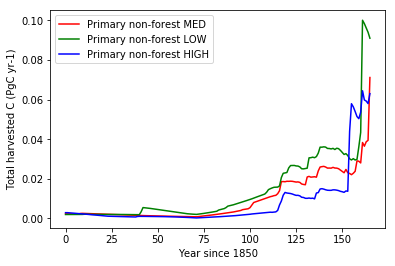

In [13]:
# Calculate the total primary forest harvest, non-forest harvest and secondary forest harvest, non-forest harvest
primf_bioh_tot = np.nansum(np.nansum(primf_bioh, 1), 1)/1e12
primn_bioh_tot = np.nansum(np.nansum(primn_bioh, 1), 1)/1e12
secmf_bioh_tot = np.nansum(np.nansum(secmf_bioh, 1), 1)/1e12
secmn_bioh_tot = np.nansum(np.nansum(secmn_bioh, 1), 1)/1e12

primf_bioh_lo_tot = np.nansum(np.nansum(primf_bioh_lo, 1), 1)/1e12
primn_bioh_lo_tot = np.nansum(np.nansum(primn_bioh_lo, 1), 1)/1e12
secmf_bioh_lo_tot = np.nansum(np.nansum(secmf_bioh_lo, 1), 1)/1e12
secmn_bioh_lo_tot = np.nansum(np.nansum(secmn_bioh_lo, 1), 1)/1e12

primf_bioh_hi_tot = np.nansum(np.nansum(primf_bioh_hi, 1), 1)/1e12
primn_bioh_hi_tot = np.nansum(np.nansum(primn_bioh_hi, 1), 1)/1e12
secmf_bioh_hi_tot = np.nansum(np.nansum(secmf_bioh_hi, 1), 1)/1e12
secmn_bioh_hi_tot = np.nansum(np.nansum(secmn_bioh_hi, 1), 1)/1e12

# Plots
plt.plot(primn_bioh_tot, 'r-')
plt.plot(primn_bioh_lo_tot, 'g-')
plt.plot(primn_bioh_hi_tot, 'b-')
# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Primary non-forest MED','Primary non-forest LOW', 'Primary non-forest HIGH'])

plt.xlabel('Year since 1850')
plt.ylabel('Total harvested C (PgC yr-1)')

Text(0,0.5,'Total harvested C (PgC yr-1)')

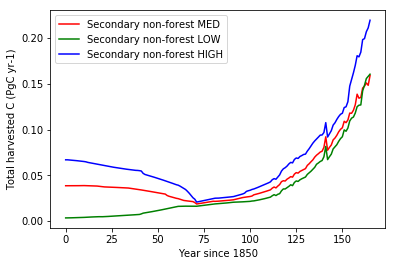

In [14]:
# Plots
plt.plot(secmn_bioh_tot, 'r-')
plt.plot(secmn_bioh_lo_tot, 'g-')
plt.plot(secmn_bioh_hi_tot, 'b-')
# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Secondary non-forest MED','Secondary non-forest LOW', 'Secondary non-forest HIGH'])

plt.xlabel('Year since 1850')
plt.ylabel('Total harvested C (PgC yr-1)')

In [ ]:
# Plots
plt.plot(primf_bioh_tot, 'r-')
plt.plot(primf_bioh_lo_tot, 'g-')
plt.plot(primf_bioh_hi_tot, 'b-')
# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Primary forest MED','Primary forest LOW', 'Primary forest HIGH'])

plt.xlabel('Year since 1850')
plt.ylabel('Total harvested C (PgC yr-1)')

In [ ]:
# Relative ratio
plt.plot(primn_bioh_tot[1000:1165]/primf_bioh_tot[1000:1165], 'r-')
plt.plot(secmn_bioh_tot[1000:1165]/secmf_bioh_tot[1000:1165], 'b-')
plt.legend(['Primary forest to non-forest ratio', 'Secondary forest to non-forest ratio'])
plt.xlabel('Year since 1850')
plt.ylabel('Ratio')

### LUH2 states

In [3]:
# Open LUH2 states dataset
fpath = 'C:/Users/sshu3/anaconda_wkspace/states.nc'
nclu=nc4.Dataset(fpath)
secf_luh2 = nclu['secdf'][:]
secn_luh2 = nclu['secdn'][:]
lat_luh2 = nclu['lat'][:]
lon_luh2 = nclu['lon'][:]

nclu.close()

# Global grid area for 0.25 deg for LUH2 datasets
nlon = 1440
nlat = 720
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-89.875, 90.125, 0.25)
res = 0.25;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

### Obs of biomass

In [35]:
# Open some observed datasets
# Tropical
filename_in = 'biomass_data_ilamb/tropical_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
tropical_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
tropical_for_c = tropical_for_c_tmp[0,:,:]

# ESACCI
filename_in = 'biomass_data_ilamb/esacci_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
esacci_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
esacci_for_c = esacci_for_c_tmp[0,:,:]

# Global Carbon
filename_in = 'biomass_data_ilamb/global_carbon_v3.nc'
fin = nc.netcdf_file(filename_in)
gc_lat = fin.variables['lat'][:]
gc_lon = fin.variables['lon'][:]
## read in variables
gc_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
gc_for_c = gc_for_c_tmp[0,:,:]

# NBCD2000
filename_in = 'biomass_data_ilamb/nbcd2000_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
nbcd2000_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
nbcd2000_for_c = nbcd2000_for_c_tmp[0,:,:]

# US Forest
filename_in = 'biomass_data_ilamb/US_forest_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
usf_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
usf_for_c = usf_for_c_tmp[0,:,:]

# Thurner
filename_in = 'biomass_data_ilamb/Thurner_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
thurner_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
thurner_for_c = thurner_for_c_tmp[0,:,:]

### Upscaled LUH2 harvest rate data

In [4]:
# Open dataset
fpath = 'C:/Users/sshu3/anaconda_wkspace/Fates/landuse.timeseries_4x5_hist_harmonized_simyr1700-2015.biomass_harvest.nc'
nclu=nc4.Dataset(fpath)
prif_hv = nclu['HARVEST_VH1'][:]
prin_hv = nclu['HARVEST_VH2'][:]
secmf_hv = nclu['HARVEST_SH1'][:]
secyf_hv = nclu['HARVEST_SH2'][:]
secn_hv = nclu['HARVEST_SH3'][:]
pct_nat_pft = nclu['PCT_NAT_PFT'][:]

nclu.close()

# Transfer into per m2 density value
prif_hv_den = prif_hv / (area_4x5*1e6)
prin_hv_den = prin_hv / (area_4x5*1e6)
secmf_hv_den = secmf_hv / (area_4x5*1e6)
secyf_hv_den = secyf_hv / (area_4x5*1e6)
secn_hv_den = secn_hv / (area_4x5*1e6)

# Aggregate the number to certain year
pri_hv = np.sum(prif_hv_den[0:166, :, :], 0) + np.sum(prin_hv_den[0:166, :, :], 0)
sec_m_hv = np.sum(secmf_hv_den[0:166, :, :], 0)
sec_y_hv = np.sum(secyf_hv_den[0:166, :, :], 0) + np.sum(secn_hv_den[0:166, :, :], 0)

# Aggregate the harvest amount
luh2_pri_hv = prif_hv + prin_hv
luh2_sec_m_hv = secmf_hv
luh2_sec_y_hv = secyf_hv + secn_hv

# Crop and bareground fraction
pct_crop = copy.deepcopy(pct_nat_pft[(yr_beg-1700):(yr_beg-1700+nyr),15,:,:])
pct_bg = copy.deepcopy(pct_nat_pft[(yr_beg-1700):(yr_beg-1700+nyr),0,:,:])
pct_nat = 100.0 - pct_crop - pct_bg


In [109]:
np.shape(luh2_pri_hv)

(316L, 46L, 72L)

### Make plots (secondary forest area)

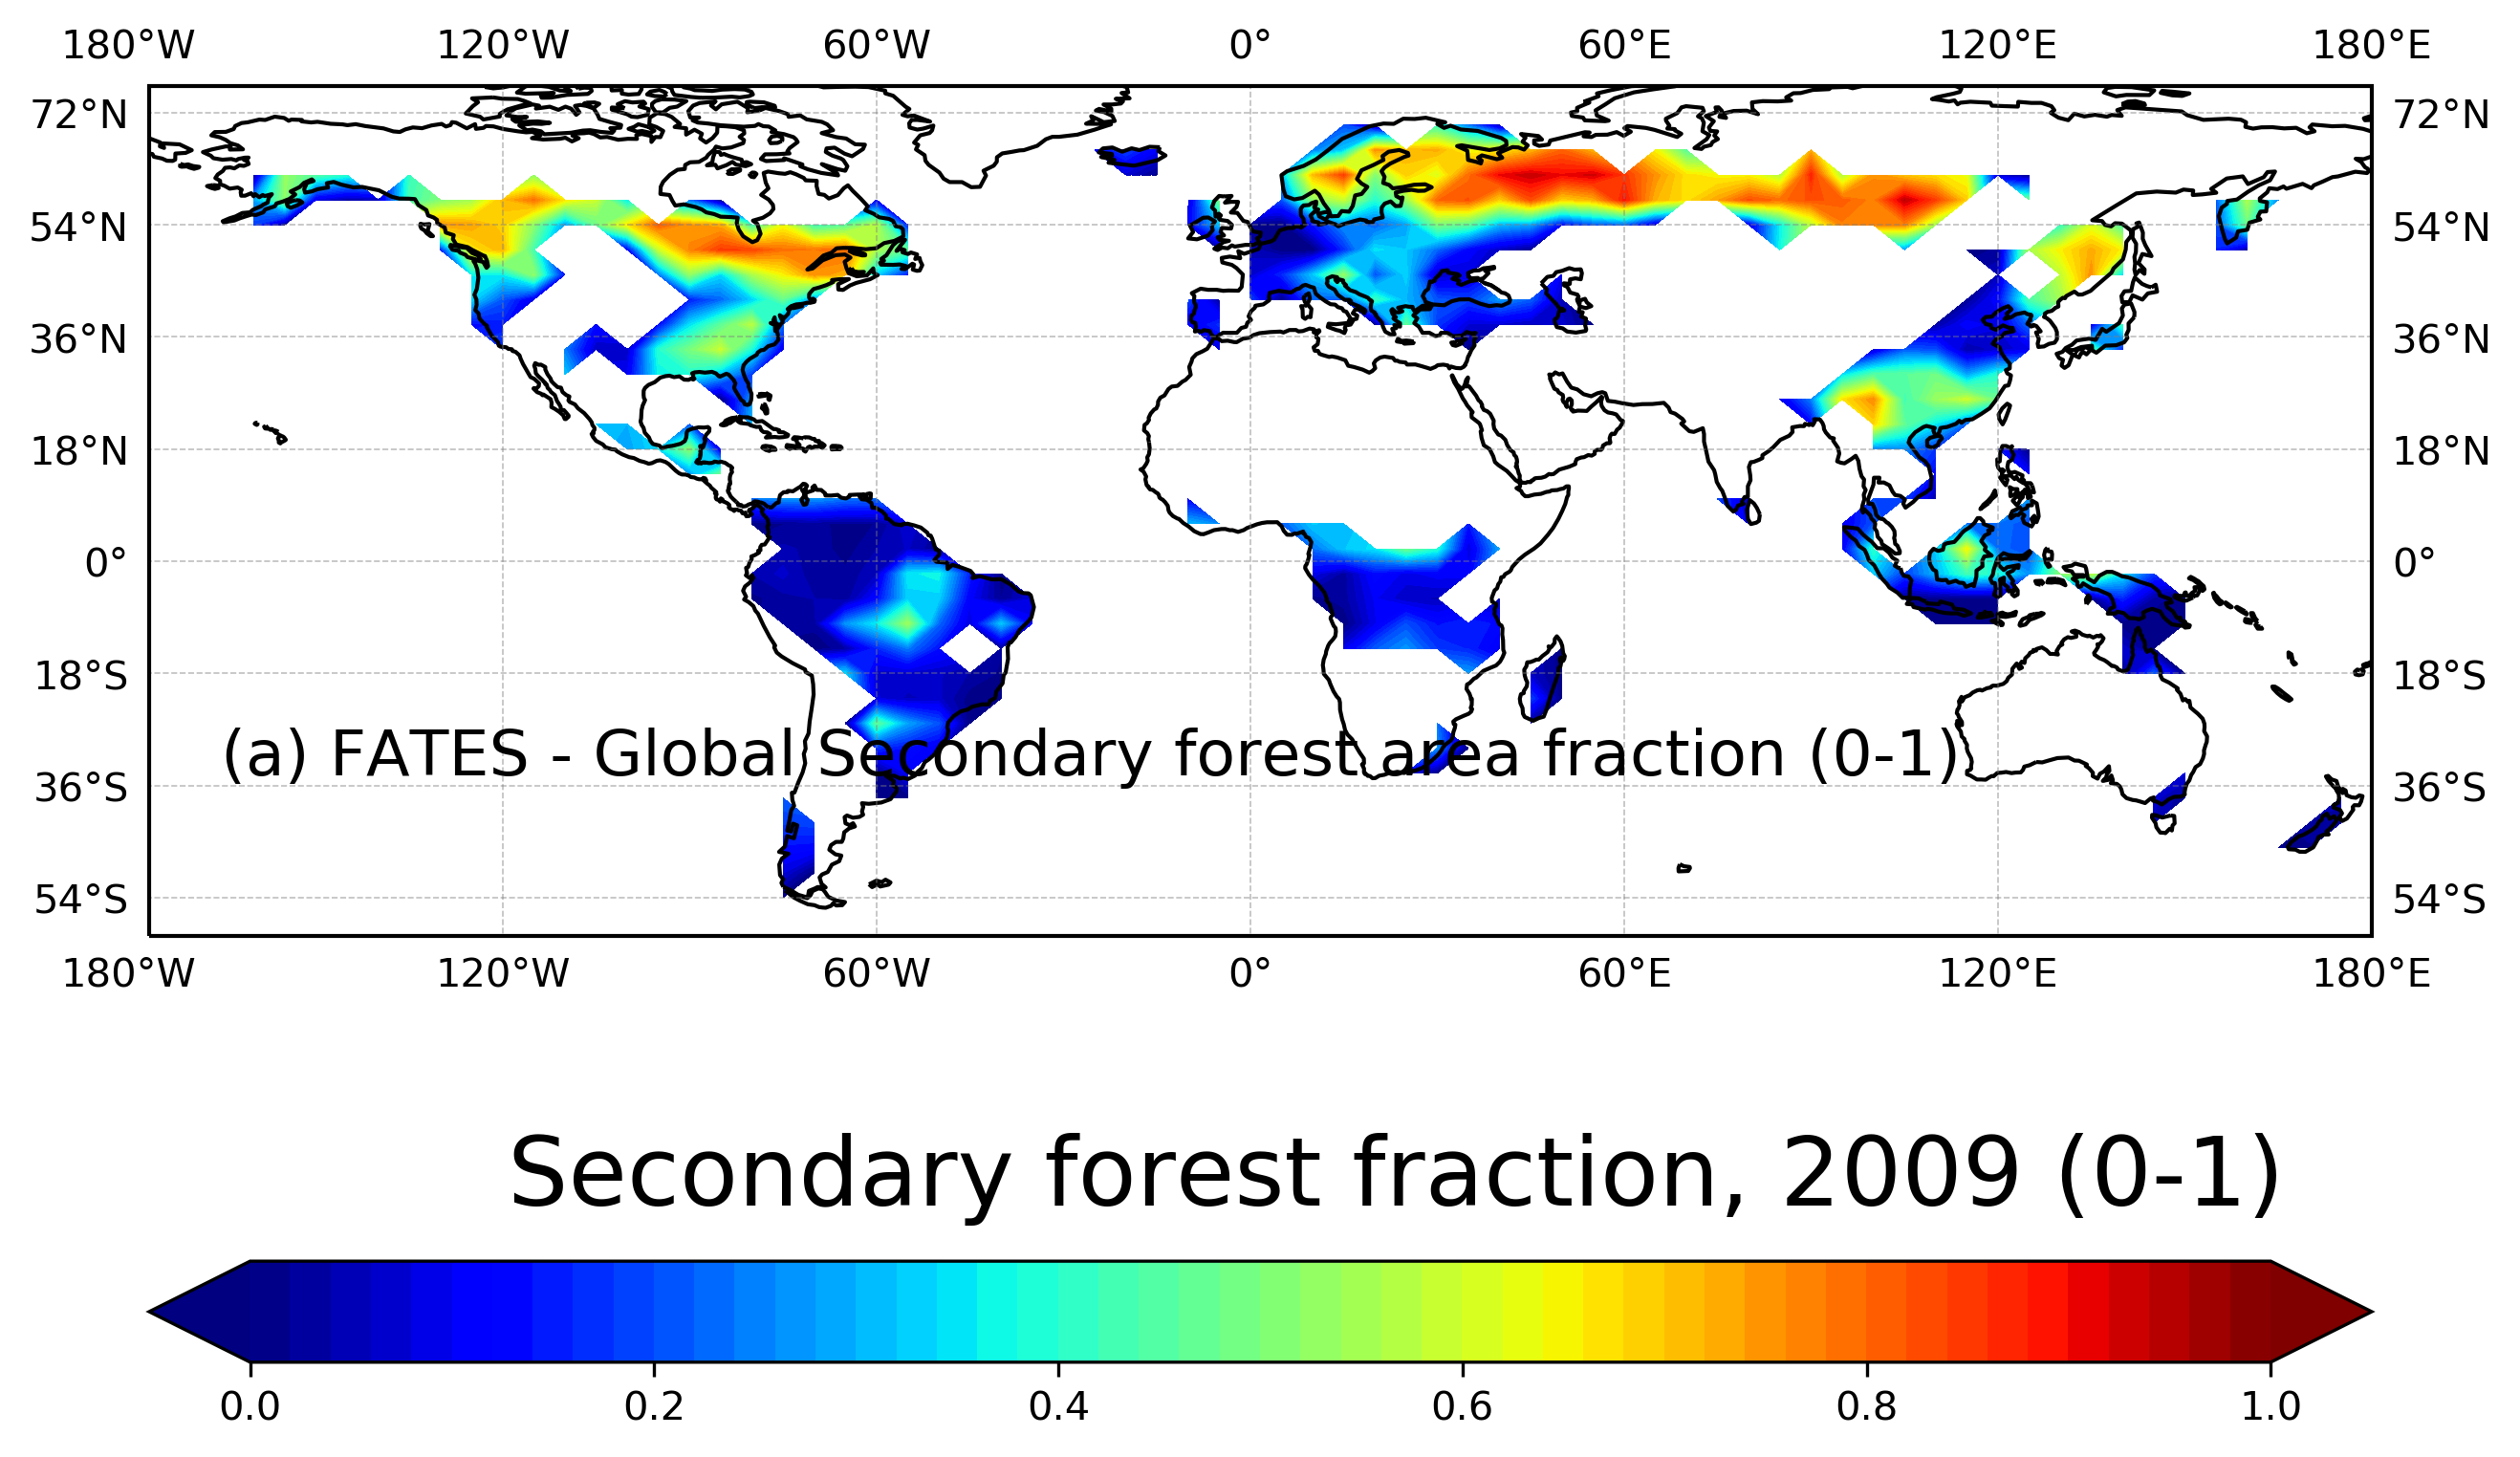

In [56]:
# Secondary forest area map at end of run (in fraction)
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])


sec_frac_new = copy.deepcopy(sec_frac[12*nyr-1,:,:])
sec_frac_new[sec_frac_new<=0] = np.float('nan')

sec_frac_new = sec_frac_new * fates_area_frac[12*nyr-1,:,:] * land_4x5 * np.nansum(pfarea[12*nyr-1,0:9,:,:], 0) * 0.01 * pct_nat[nyr-1,:,:]
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, sec_frac_new[:,:], 60, levels=np.linspace(0.0, 1.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) FATES - Global Secondary forest area fraction (0-1)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest fraction, 2009 (0-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
#plt.show()
plt.savefig('SEC_VEGFRAC.png')

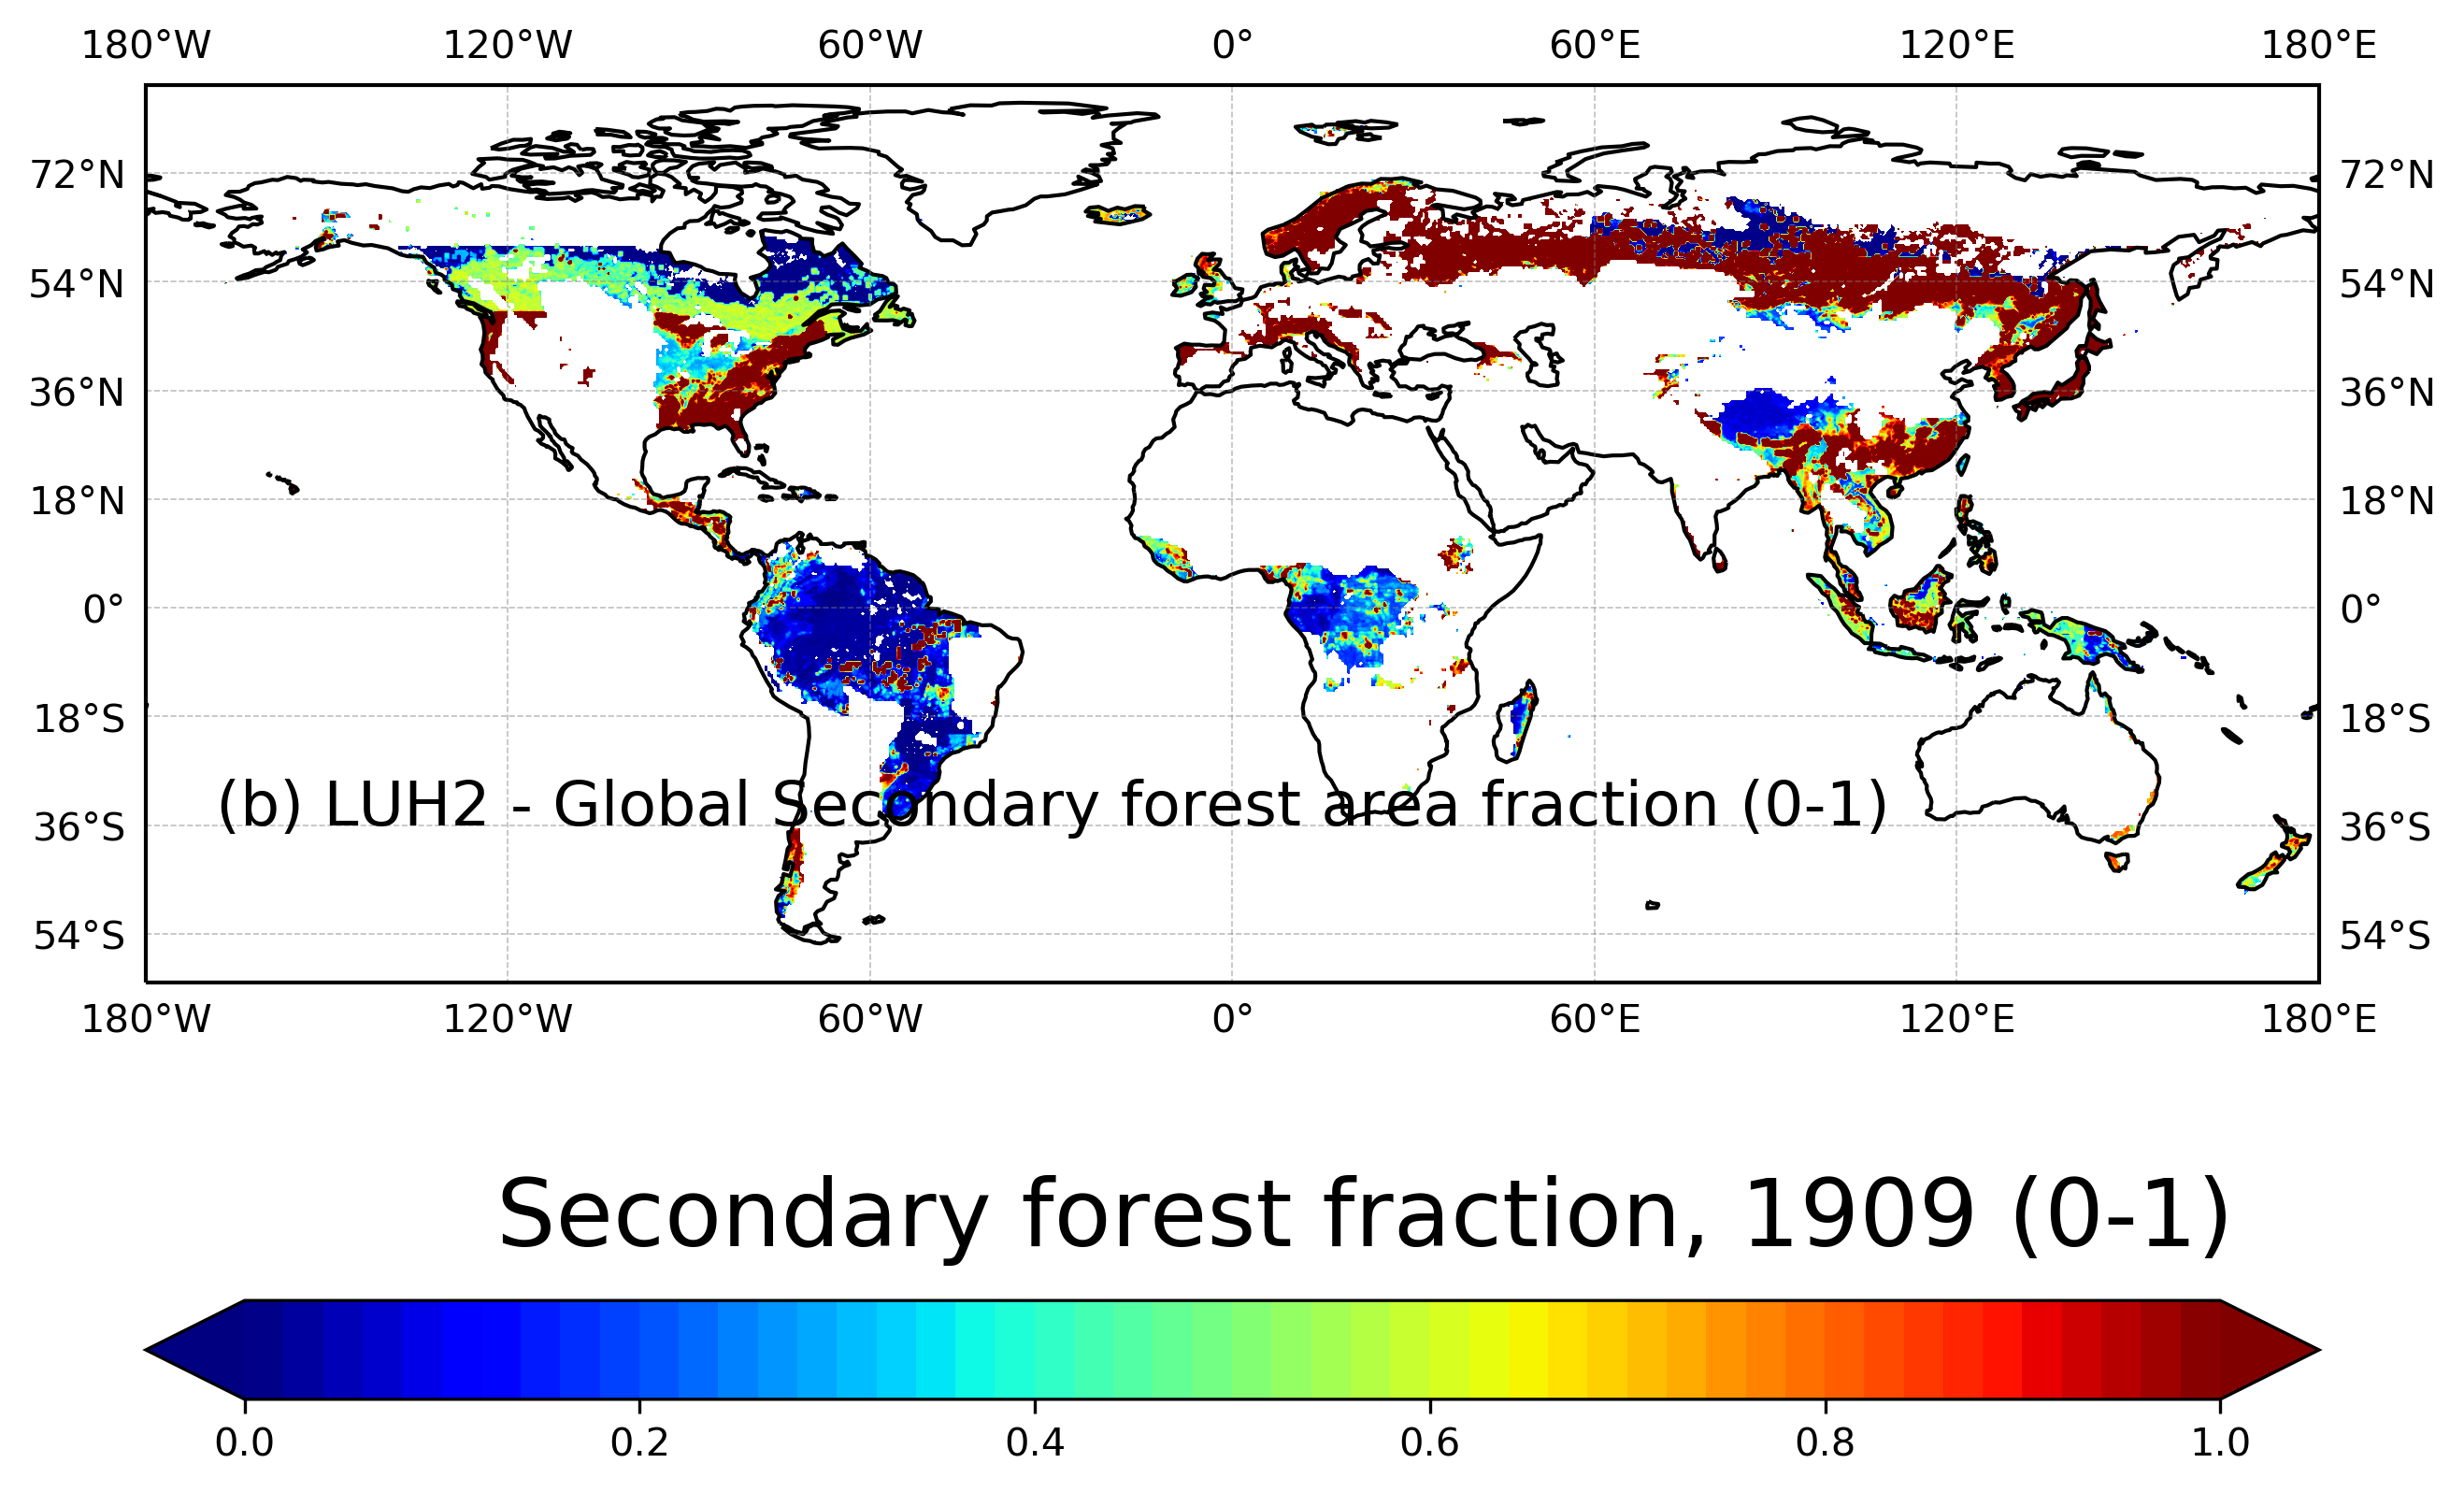

In [53]:
# Secondary forest area map from LUH2 (in fraction)
sec_tot = secf_luh2+secn_luh2
sec_tot[secf_luh2<=0.0] = np.float('nan')

fig = plt.figure(figsize=(10,10), dpi=300)

ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lon_luh2, lat_luh2, secf_luh2[1165,:,:]+sec_tot[1165,:,:], 60, levels=np.linspace(0.0, 1.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(b) LUH2 - Global Secondary forest area fraction (0-1)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest fraction, 1909 (0-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
#plt.show()
plt.savefig('SEC_VEGFRAC_LUH2.png')

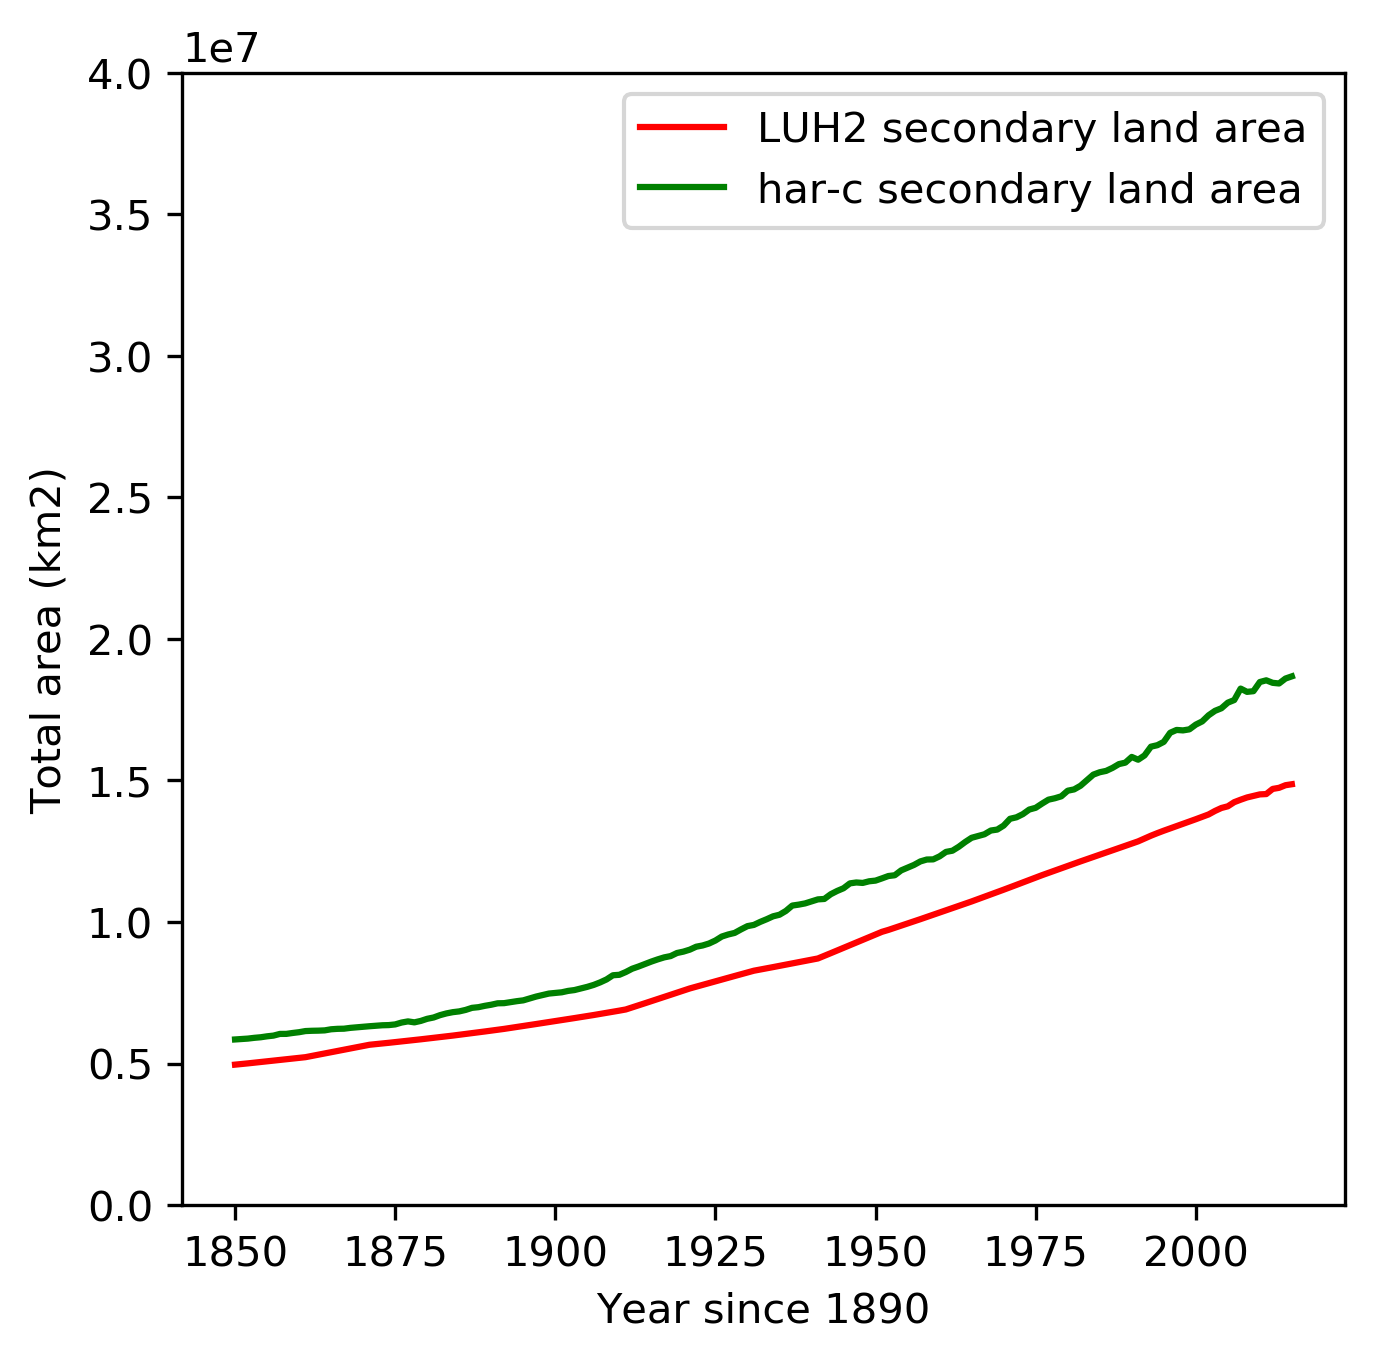

In [14]:
# Calculate the time series of secondary forest area 
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)
sec_tot = secf_luh2+secn_luh2
sec_tot[secf_luh2<=0.0] = np.float('nan')
seca_luh2 = copy.deepcopy(sec_tot[(1165-nyr):1165,:,:])
for i in np.arange(0,nyr):
    seca_luh2[i,:,:] = sec_tot[(1165-nyr+i),:,:] * grid_area

# m2 to km2
seca_luh2_tot = np.nansum(np.nansum(seca_luh2, 1), 1)/1e6

seca_fates = copy.deepcopy(sec_frac[0:nyr,:,:])
# Secondary forest area from FATES
# area_4x5 --- grid area
# land_4x5 --- land mask
# fates_area_frac --- area fraction excluding water body 
# 0.01 * pct_nat --- fraction of area after excluding crop and bareground
# pfarea --- fraction of area for each FATES PFT, to exclude grassland
for i in np.arange(0,nyr):
#     seca_fates[i,:,:] = sec_frac[12*i,:,:]*area_4x5*land_4x5*fates_area_frac[12*i,:,:]*0.01*pct_nat[i,:,:]*np.nansum(pfarea[12*i,0:6,:,:], 0)
    # Another equation considering crown area only
    seca_fates[i,:,:] = sec_frac[12*i,:,:]*area_4x5*land_4x5*fates_area_frac[12*i,:,:]*0.01*pct_nat[i,:,:]*np.nansum(pfarea[12*i,0:6,:,:], 0)*np.nansum(cr_area_pf[12*i,0:6,:,:], 0)

# Unit from FATES is already in km2
seca_fates_tot = np.nansum(np.nansum(seca_fates, 1), 1)

# Plots
plt.plot(yr_axis, seca_luh2_tot, 'r-')
plt.plot(yr_axis, seca_fates_tot, 'g-')

# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['LUH2 secondary land area','har-c secondary land area'])
plt.ylim([0,4e7])
plt.xlabel('Year since 1890')
plt.ylabel('Total area (km2)')
plt.savefig('SEC_VEGFRAC_TS.png')

### Make plots (harvested woody C)

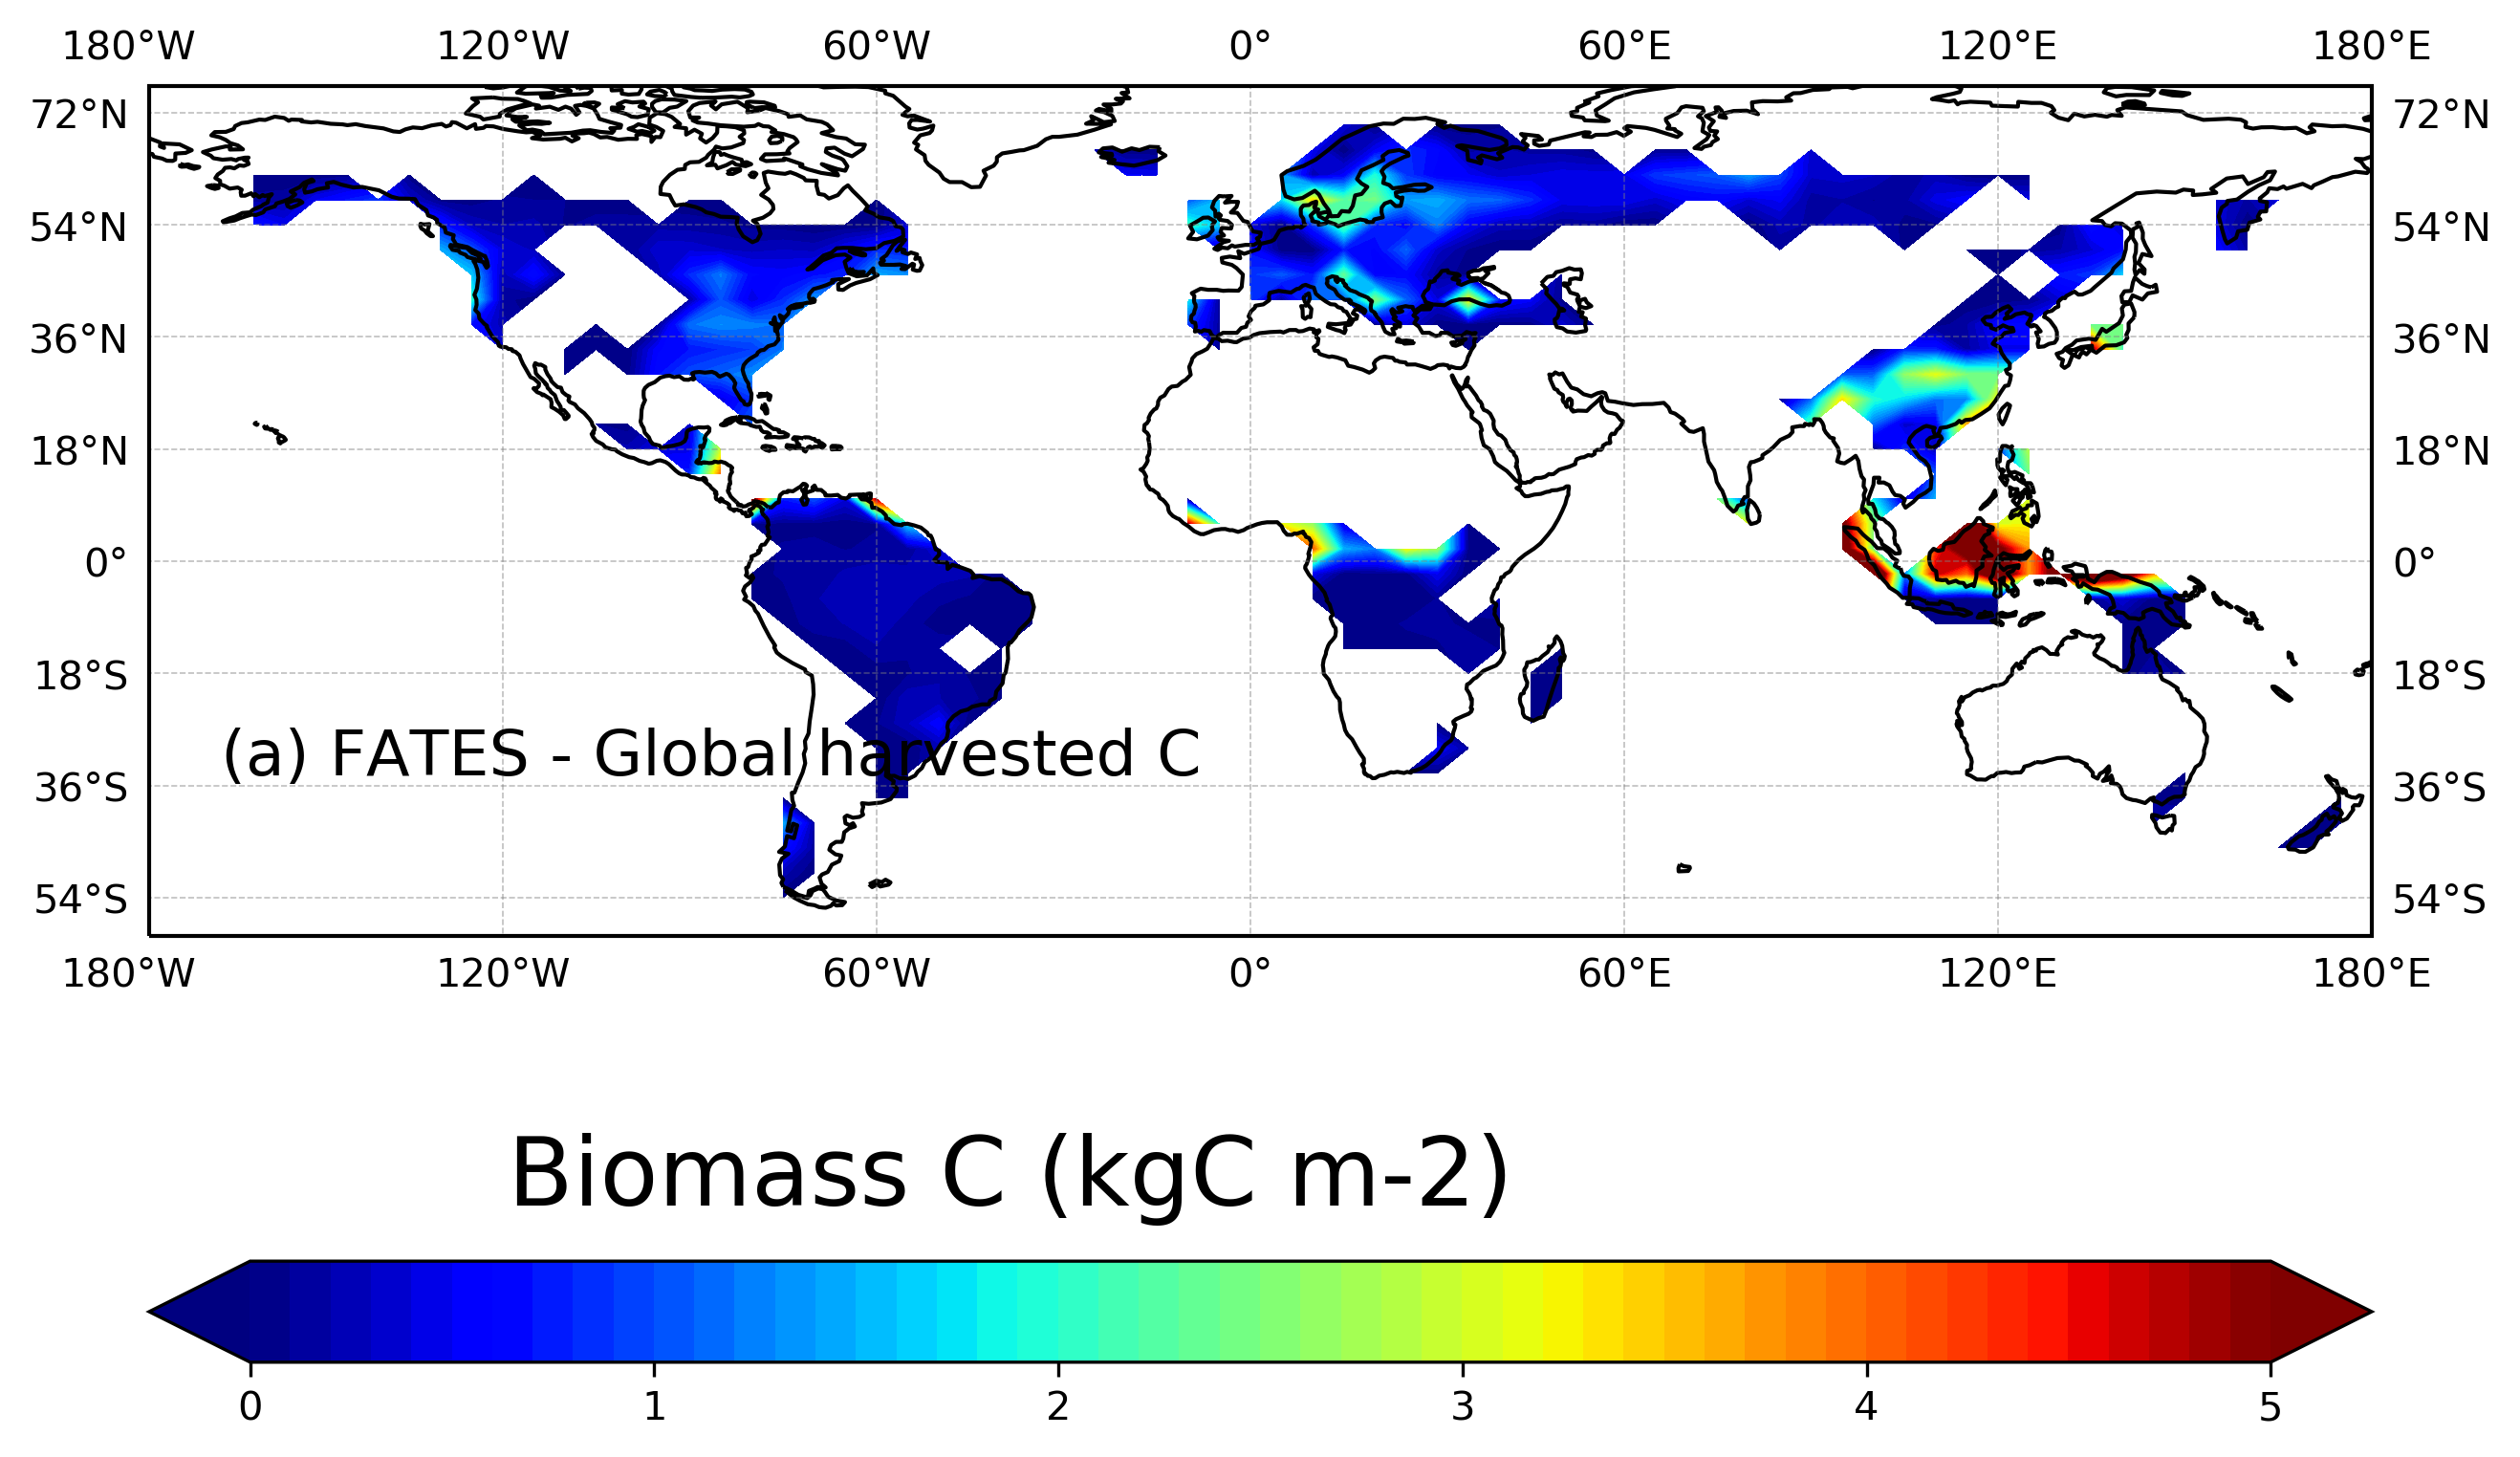

In [117]:
# Harvested C
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

hrvc_new = copy.deepcopy(hrvc[12*60-1,:,:])
hrvc_new[hrvc_new<=0] = np.float('nan')

ax = plt.axes(projection=ccrs.PlateCarree())
cs = plt.contourf(lonnc_new, latnc_new, hrvc_new[:,:], 60, levels=np.linspace(0.0, 5.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) FATES - Global harvested C', fontsize=16)
fig.text(0.25, 0.22, 'Biomass C (kgC m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 1.0, 2.0, 3.0, 4.0, 5.0] )
#plt.show()
plt.savefig('HRV_C_FATES.png')

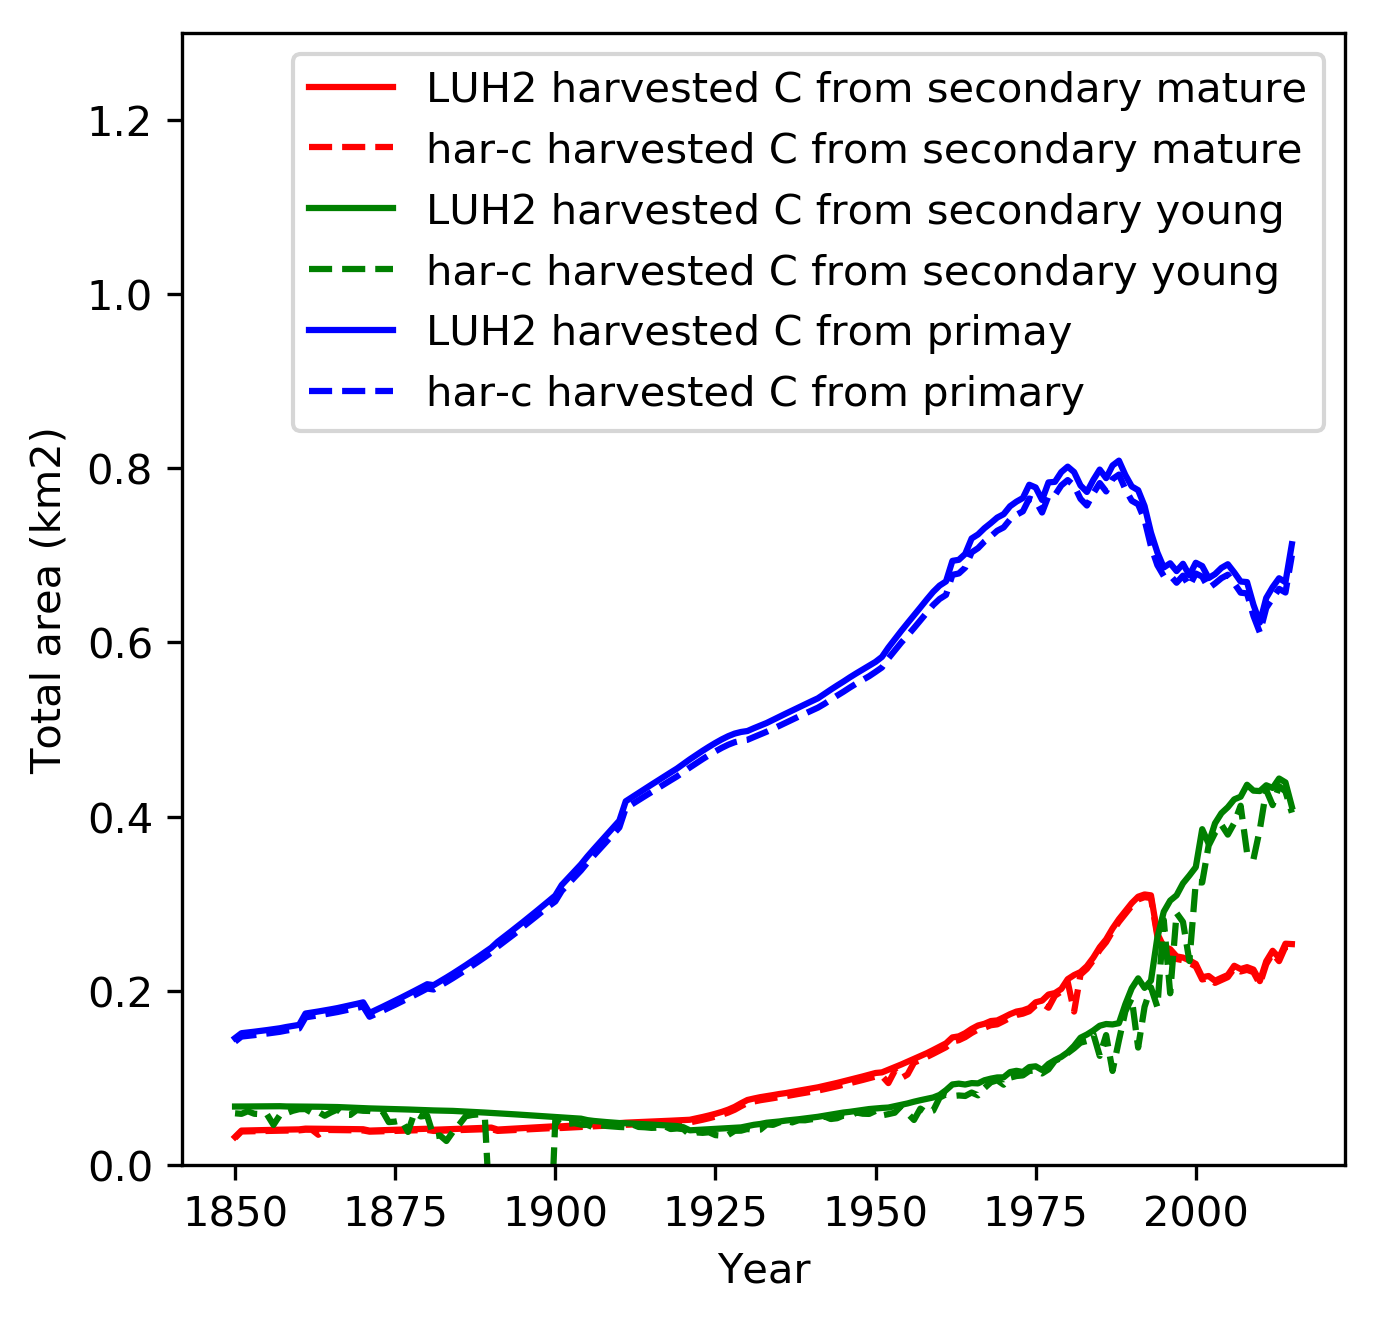

In [7]:
# # Time series of harvested C from 1) product pool and 2) hrv_debt
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)
luh2_hrv = luh2_pri_hv+luh2_sec_m_hv+luh2_sec_y_hv
luh2_hrv[luh2_hrv<=0.0] = np.float('nan')

# kgC to PgC
luh2_hrv_tot = np.nansum(np.nansum(luh2_hrv, 1), 1)*1e-12
luh2_hrv_sec_m = np.nansum(np.nansum(luh2_sec_m_hv, 1), 1)*1e-12
luh2_hrv_sec_y = np.nansum(np.nansum(luh2_sec_y_hv, 1), 1)*1e-12

hrvc_fates = copy.deepcopy(hrvc[0:nyr,:,:])
hrvc_fates_sec_m = copy.deepcopy(hrvc[0:nyr,:,:])
hrvc_fates_sec_y = copy.deepcopy(hrvc[0:nyr,:,:])

# acc_hrvc_fates = copy.deepcopy(hrvc[0:nyr,:,:])
# Secondary forest area from FATES
# area_4x5 --- grid area
# land_4x5 --- land mask
# fates_area_frac --- area fraction excluding water body 
# 0.01 * pct_nat --- fraction of area after excluding crop and bareground
# pfarea --- fraction of area for each FATES PFT, to exclude grassland

# for i in np.arange(0,nyr):
#     acc_hrvc_fates[i,:,:] = hrvc[12*i,:,:]*area_4x5*1e6
#     if(i > 0):
#         hrvc_fates[i,:,:] = acc_hrvc_fates[i,:,:] - acc_hrvc_fates[i-1,:,:]

for i in np.arange(0,nyr):
    hrvc_fates[i,:,:] = luh2_hrv[yr_beg-1700+i,:,:] - hrv_debt[12*i+1,:,:]
    hrvc_fates_sec_m[i,:,:] = luh2_sec_m_hv[yr_beg-1700+i,:,:] - hrv_debt_sec_m[12*i+1,:,:]
    hrvc_fates_sec_y[i,:,:] = luh2_sec_y_hv[yr_beg-1700+i,:,:] - hrv_debt_sec_y[12*i+1,:,:]

# Unit from kgC to PgC
hrvc_fates_tot = np.nansum(np.nansum(hrvc_fates, 1), 1)*1e-12
hrvc_fates_sec_m_tot = np.nansum(np.nansum(hrvc_fates_sec_m, 1), 1)*1e-12
hrvc_fates_sec_y_tot = np.nansum(np.nansum(hrvc_fates_sec_y, 1), 1)*1e-12
# hrvc_fates_tot[0] = np.float('nan')

# Plots
plt.plot(yr_axis, luh2_hrv_sec_m[(yr_beg-1700):(yr_beg-1700+nyr)], 'r-')
plt.plot(yr_axis, hrvc_fates_sec_m_tot, 'r--')
plt.plot(yr_axis, luh2_hrv_sec_y[(yr_beg-1700):(yr_beg-1700+nyr)], 'g-')
plt.plot(yr_axis, hrvc_fates_sec_y_tot, 'g--')
plt.plot(yr_axis, luh2_hrv_tot[(yr_beg-1700):(yr_beg-1700+nyr)]-luh2_hrv_sec_m[(yr_beg-1700):(yr_beg-1700+nyr)]-luh2_hrv_sec_y[(yr_beg-1700):(yr_beg-1700+nyr)], 'b-')
plt.plot(yr_axis, hrvc_fates_tot - hrvc_fates_sec_m_tot - hrvc_fates_sec_y_tot, 'b--')

# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['LUH2 harvested C from secondary mature','har-c harvested C from secondary mature', 
           'LUH2 harvested C from secondary young','har-c harvested C from secondary young',
           'LUH2 harvested C from primay','har-c harvested C from primary'])
plt.ylim([0,1.3])
plt.xlabel('Year')
plt.ylabel('Total area (km2)')
plt.savefig('HRV_C_FATES_TS.png')

### Explore certain variables: GPP from secondary forest

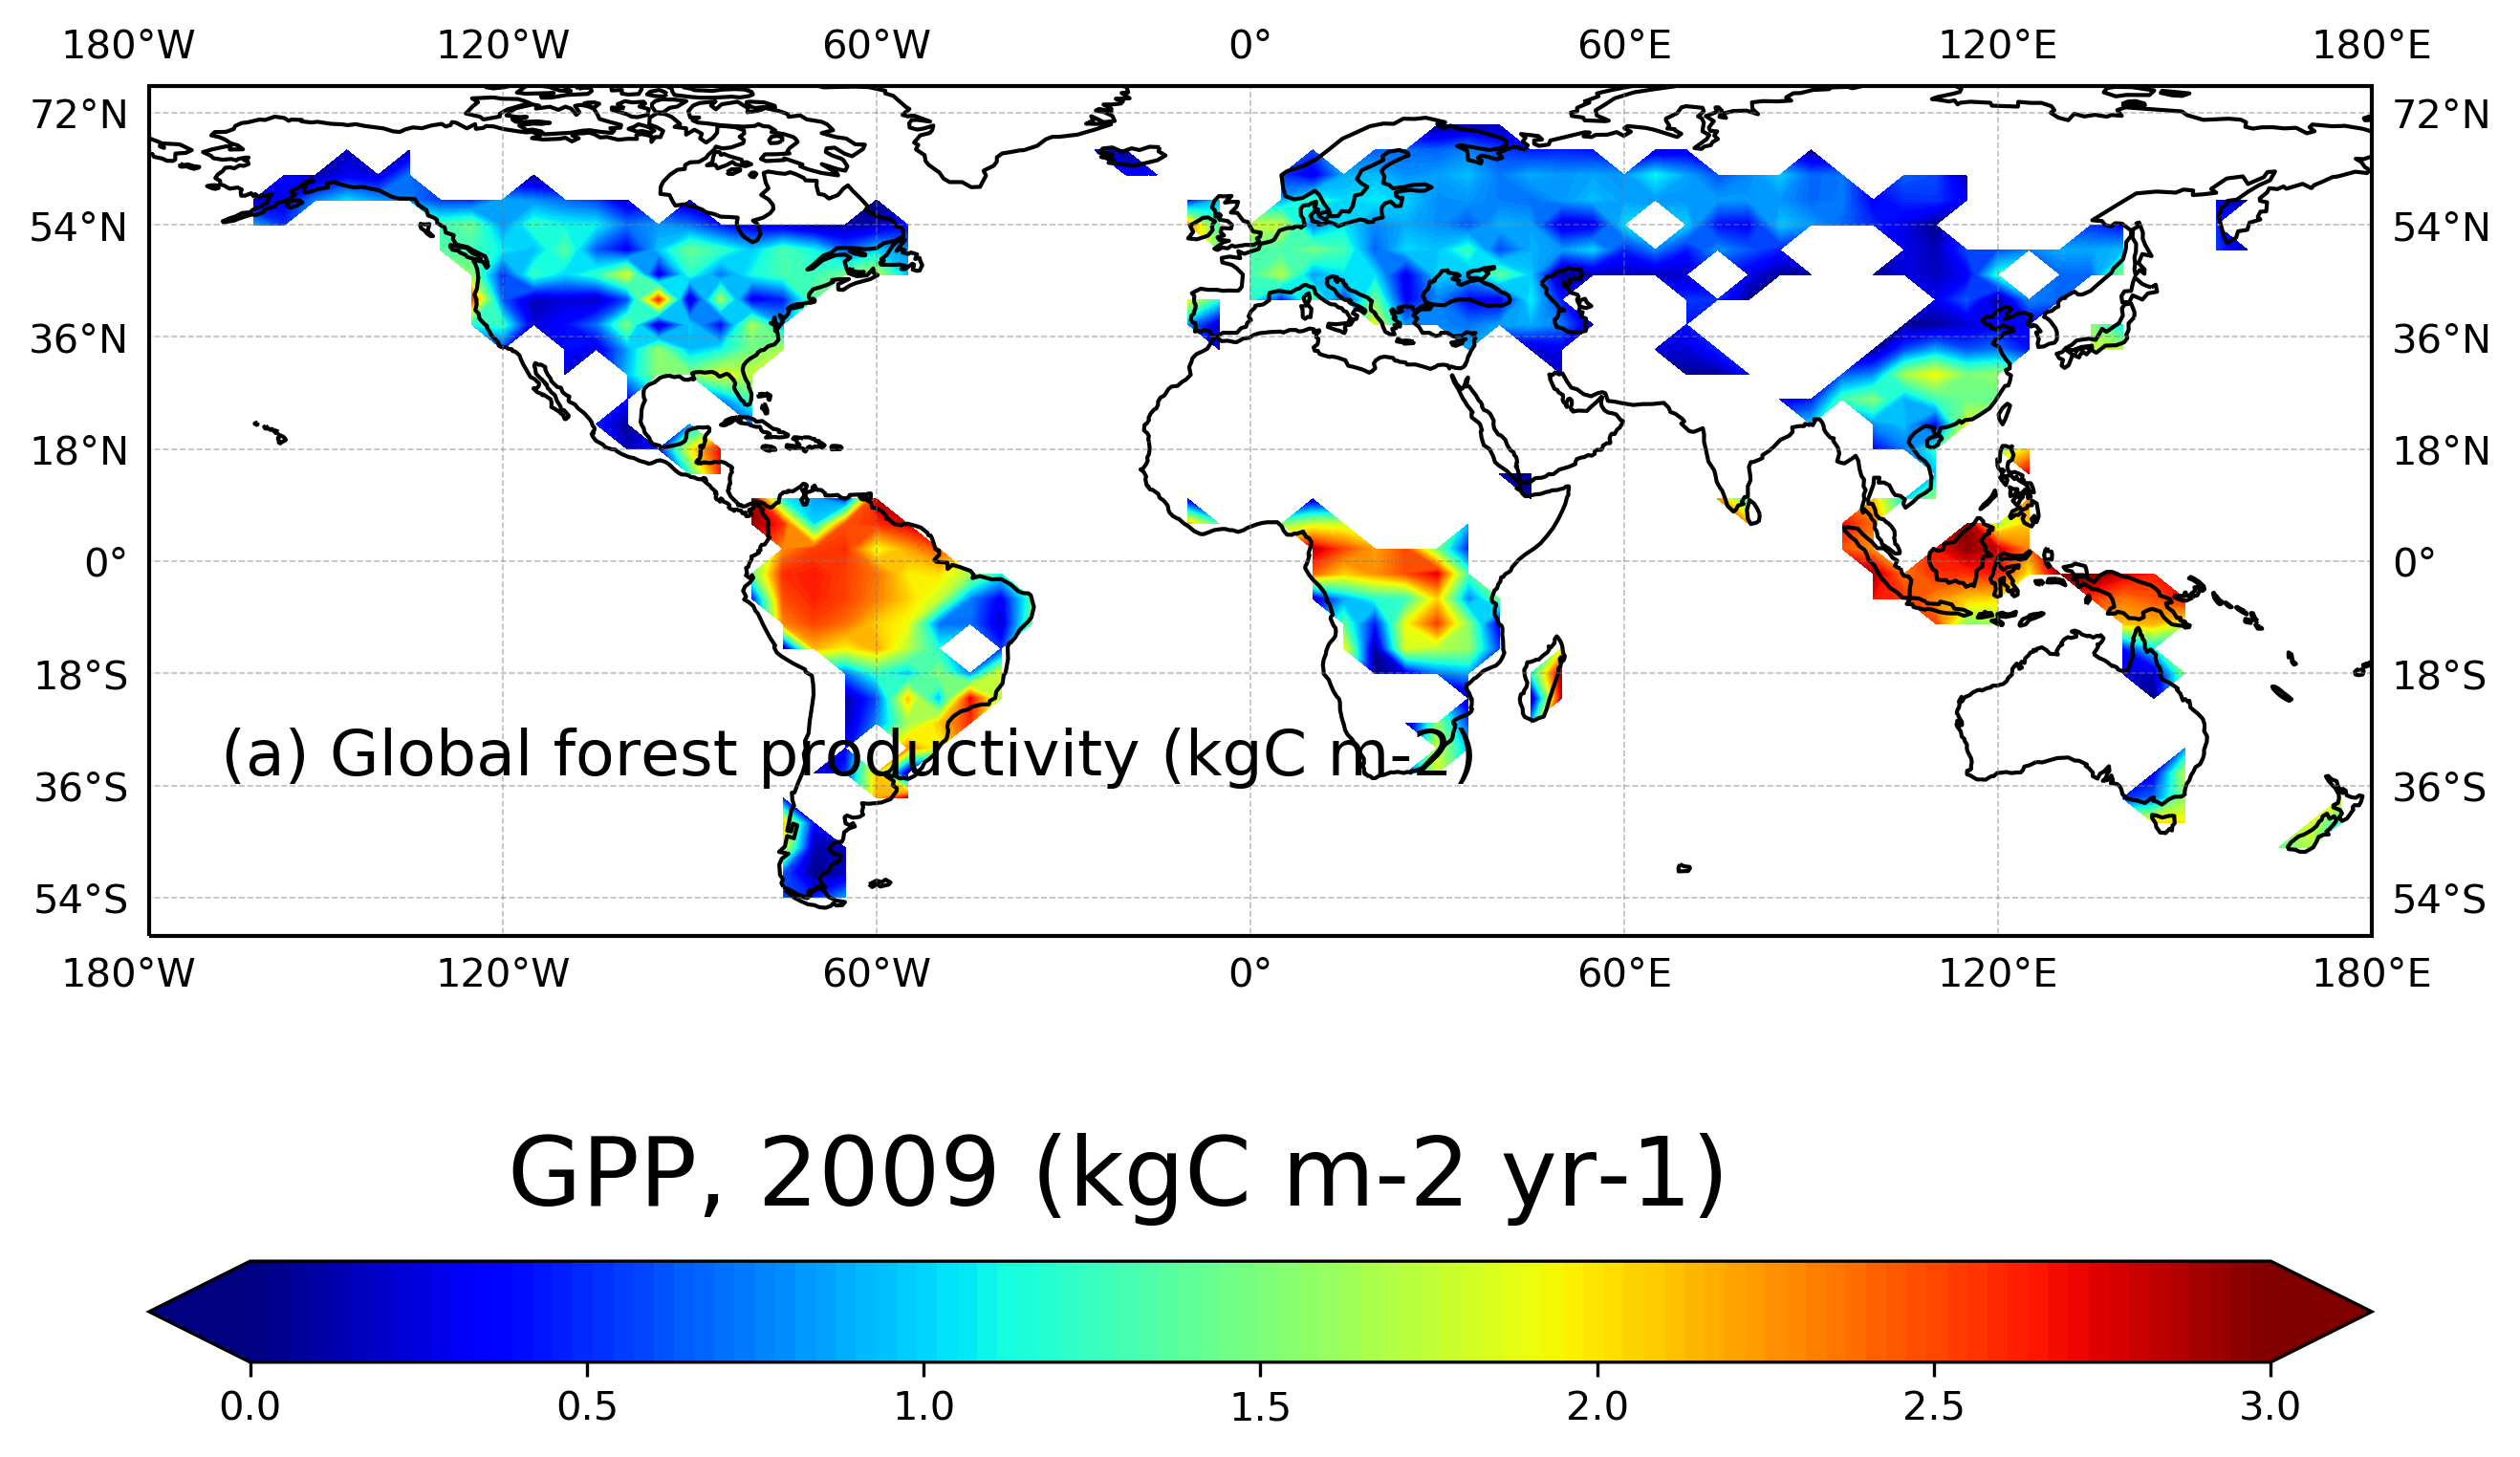

In [8]:
# Total forest biomass
# Productivity map
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365


gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.savefig('FATES_GPP.png')

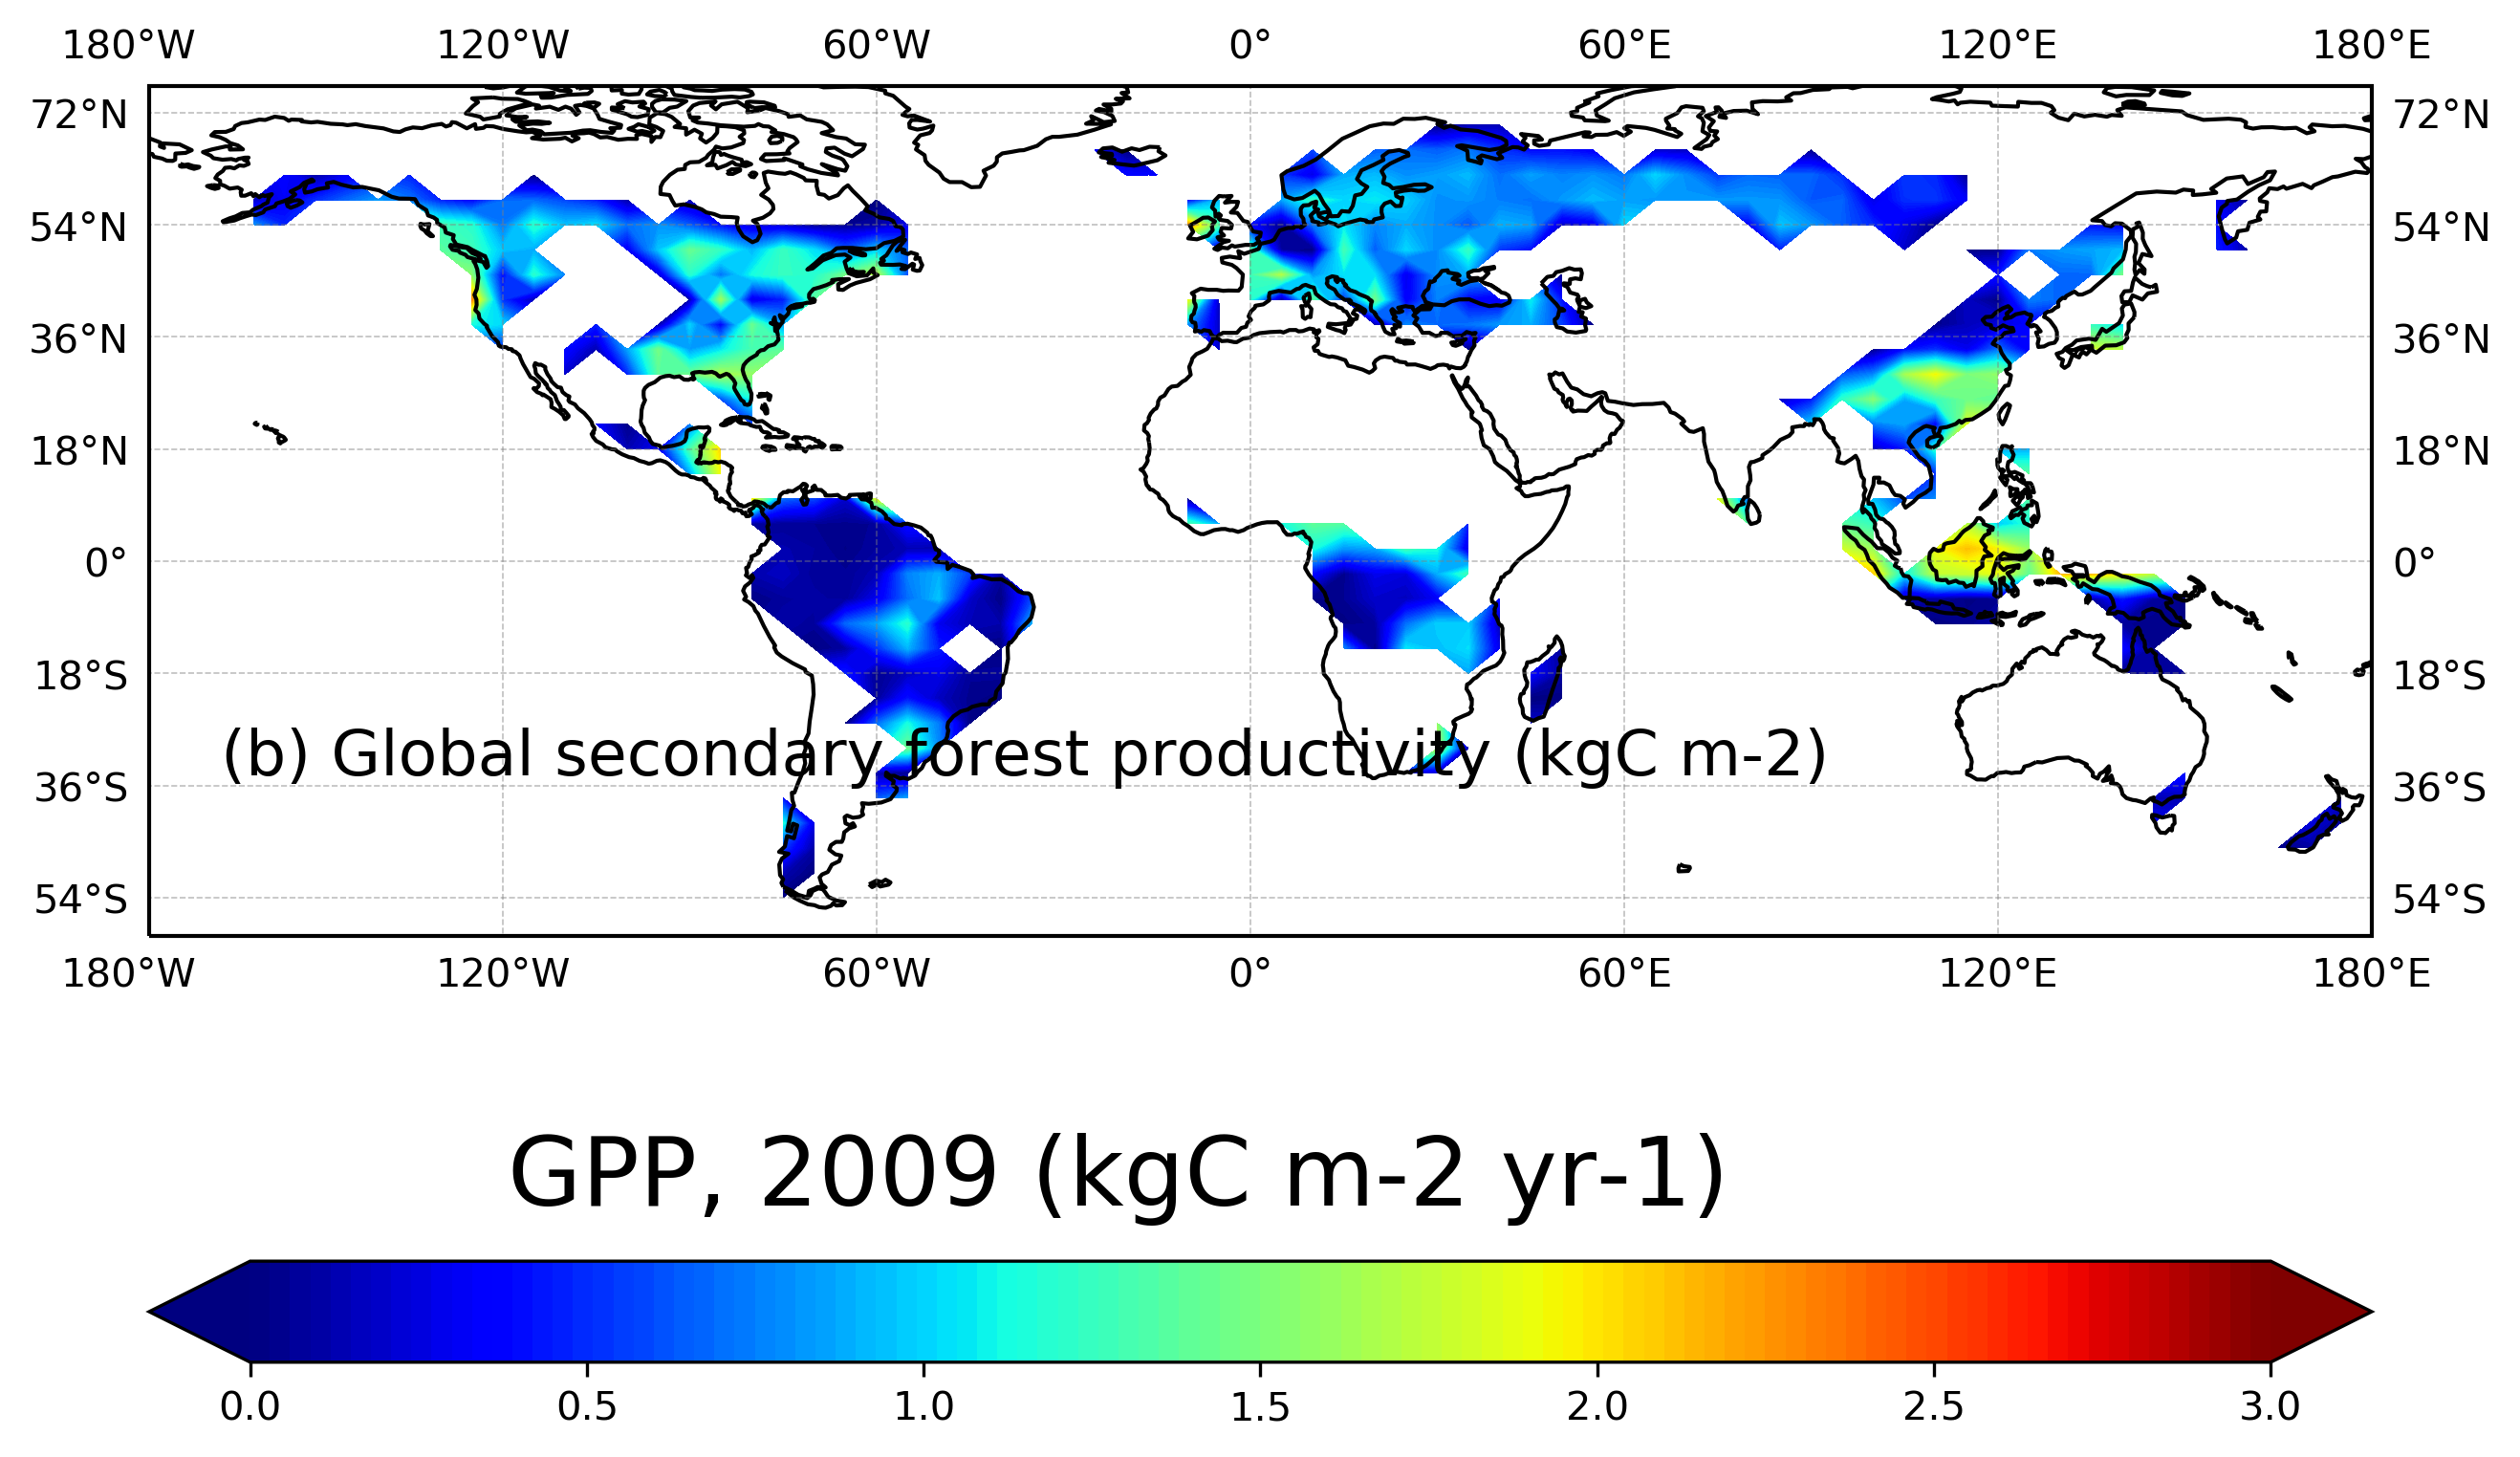

In [9]:
# Productivity map from secondary forest
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp_sec[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365

gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(b) Global secondary forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.savefig('FATES_GPP_SEC.png')

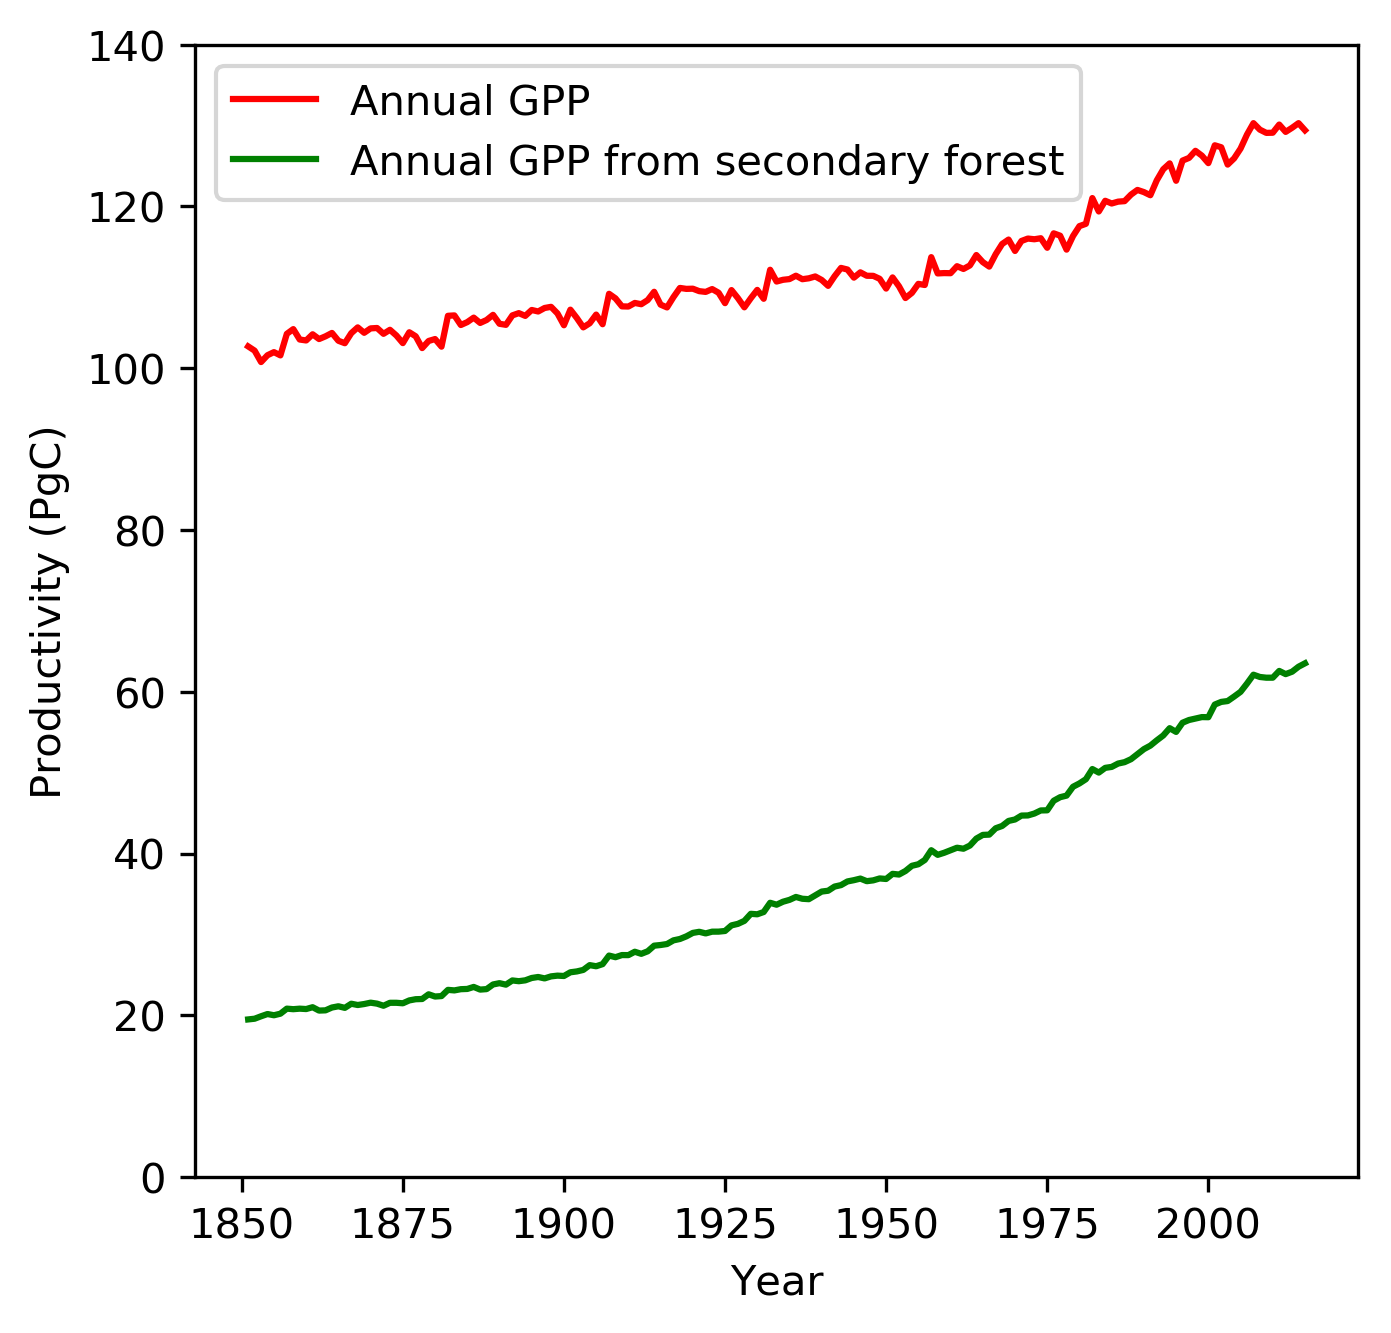

In [12]:
# Time series of the GPP contribution from secondary forest
# Calculate the time series of secondary forest area 
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)

sec_tot = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365
# unit of agpp: kgC m-2 yr-1
agpp = copy.deepcopy(gpp[(nyr*12-nyr):(nyr*12),:,:])
agpp_sec = copy.deepcopy(gpp_sec[(nyr*12-nyr):(nyr*12),:,:])
for i in np.arange(0,nyr):
    agpp[i,:,:] = np.mean(gpp[(i*12-12):(i*12),:,:], 0)*3600*24*365
    agpp_sec[i,:,:] = np.mean(gpp_sec[(i*12-12):(i*12),:,:], 0)*3600*24*365

# kgC to PgC
agpp_global = np.nansum(np.nansum(agpp*area_4x5*1e6, 1), 1)  / 1e12
agpp_sec_global = np.nansum(np.nansum(agpp_sec*area_4x5*1e6, 1), 1)  / 1e12

# Plots
plt.plot(yr_axis, agpp_global, 'r-')
plt.plot(yr_axis, agpp_sec_global, 'g-')

# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Annual GPP','Annual GPP from secondary forest'])
plt.ylim([0,140])
plt.xlabel('Year')
plt.ylabel('Productivity (PgC)')
plt.savefig('SEC_GPP_TS.png')


### Explore certain variables: Albedo

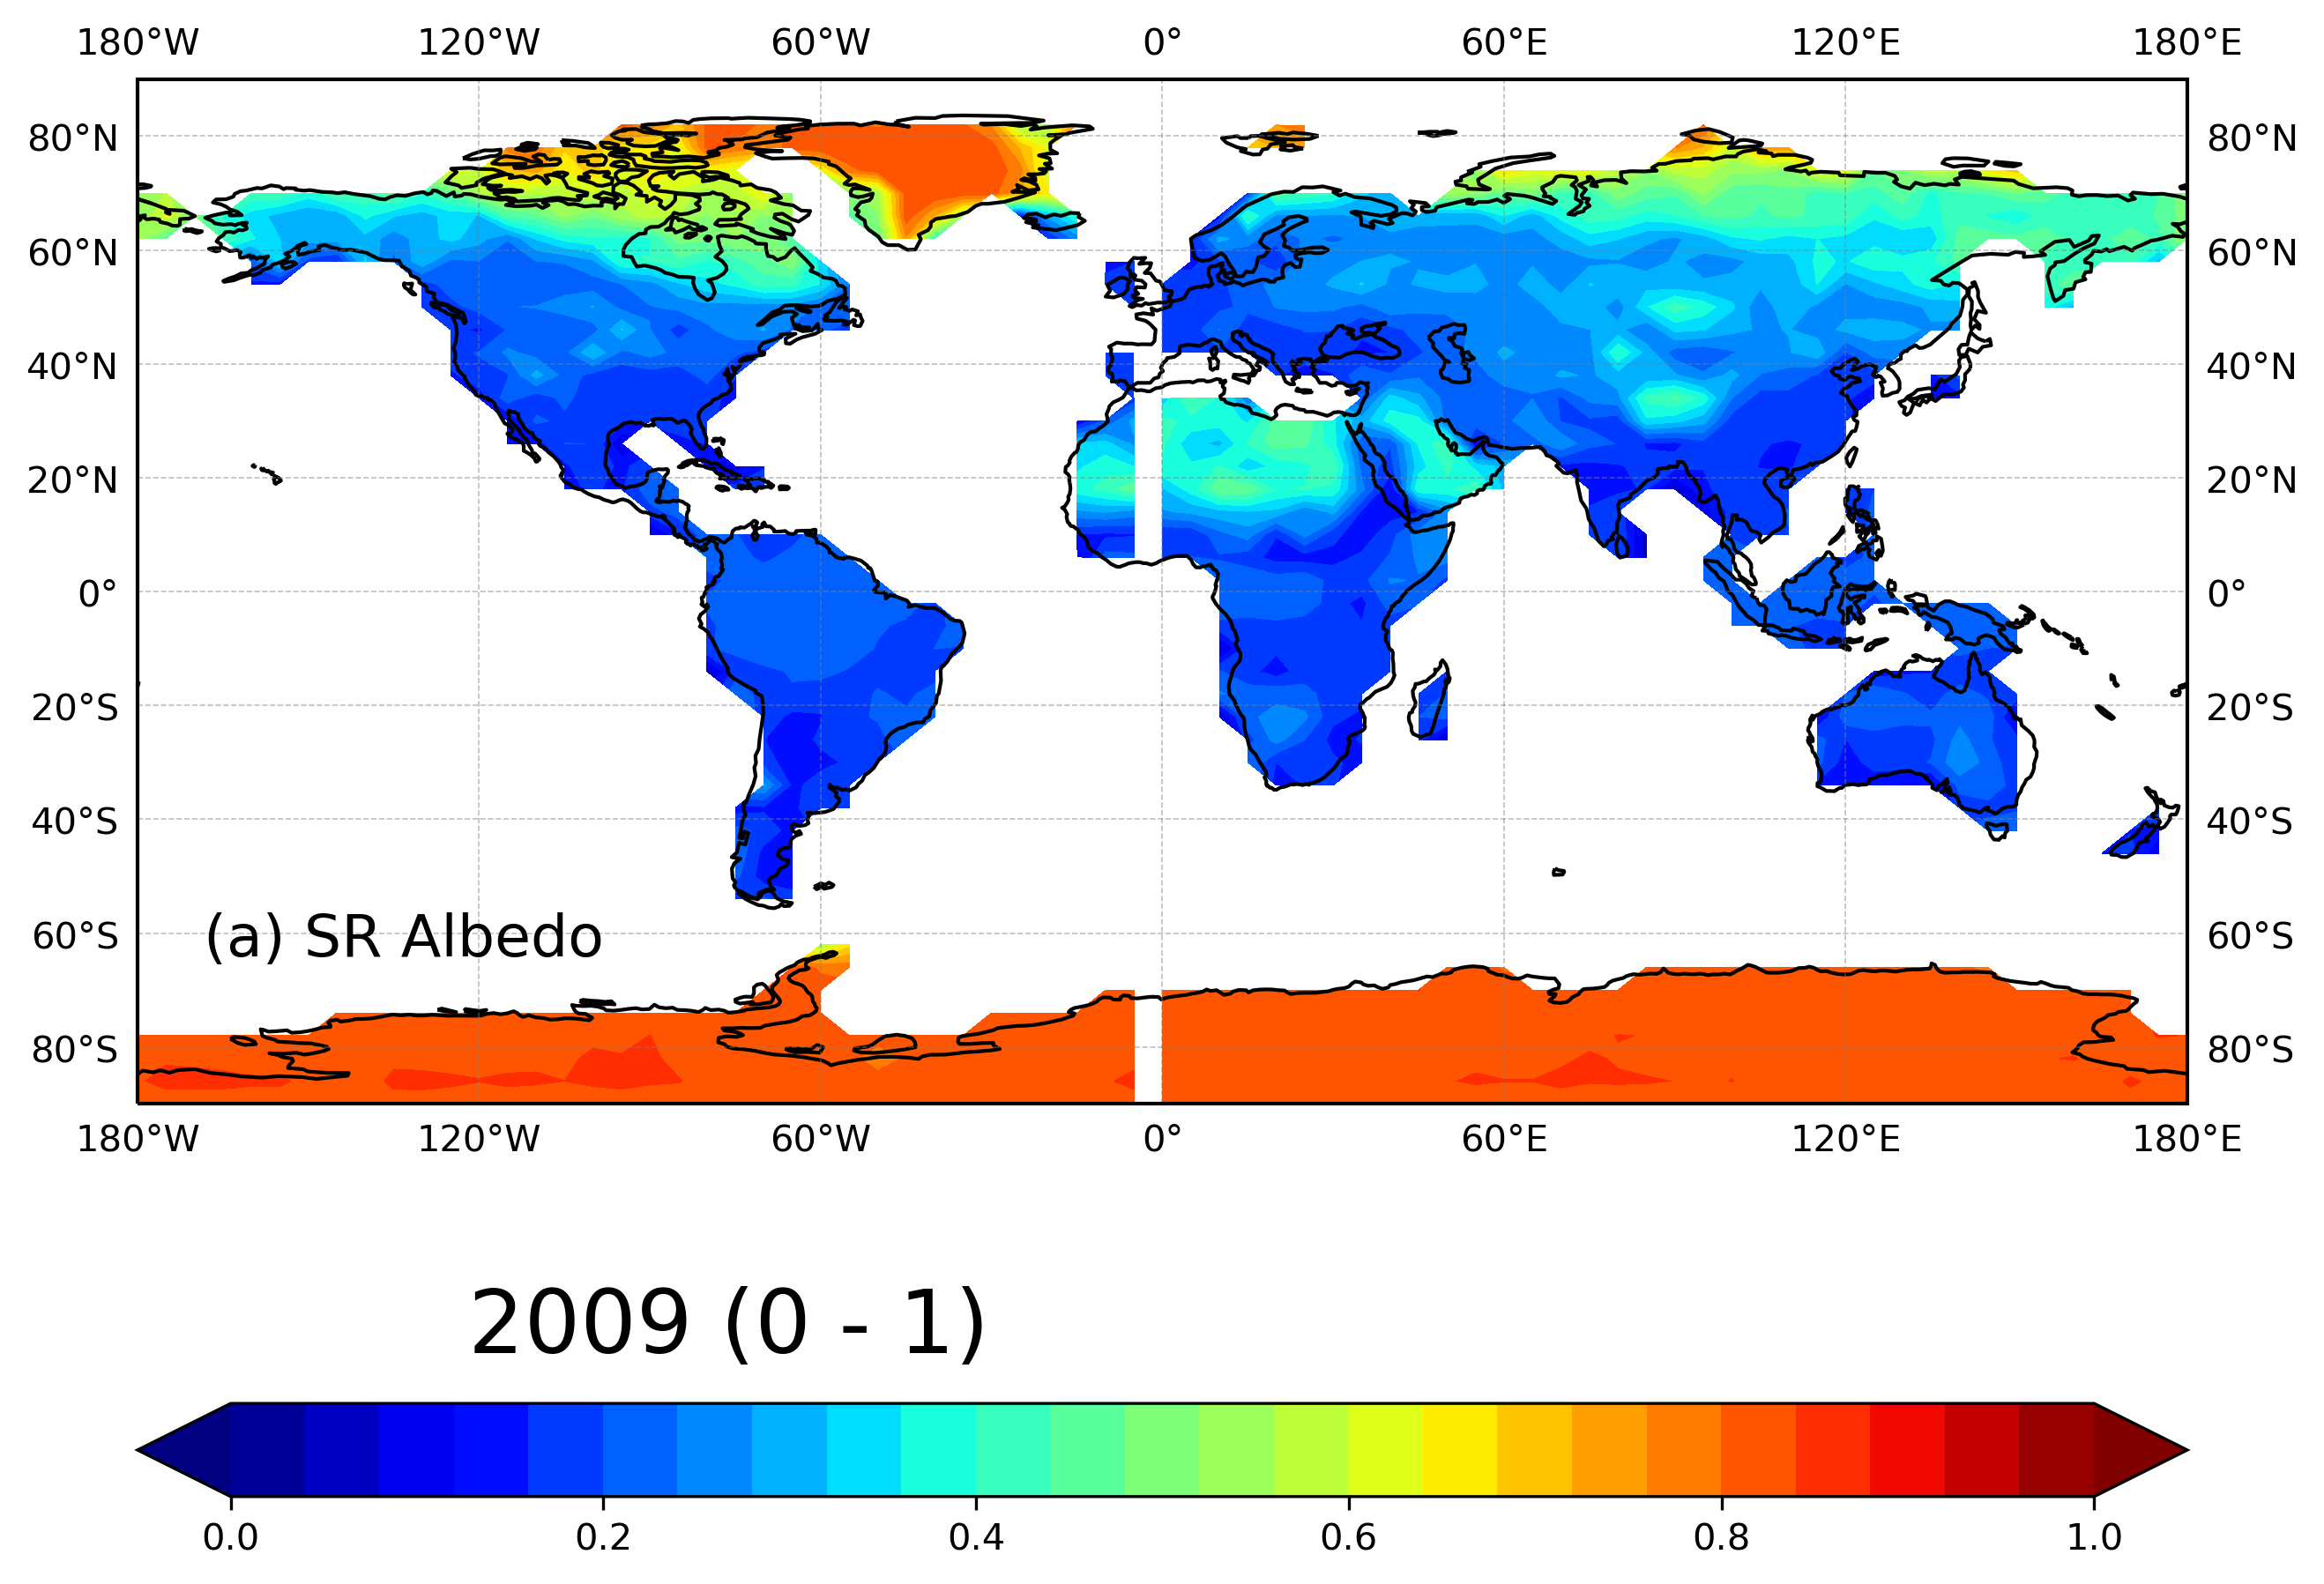

In [29]:
# Check albedo
fig = plt.figure(figsize=(10,10), dpi=300)
alb = copy.deepcopy(np.mean(ref_sr[(nyr*12-12):(nyr*12),:,:], 0)/np.mean(tot_sr[(nyr*12-12):(nyr*12),:,:], 0))

alb[alb<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, alb[:,:], 60, levels=np.linspace(0.0, 1.0, 26), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) SR Albedo', fontsize=16)
fig.text(0.25, 0.22, '2009 (0 - 1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
plt.savefig('FATES_albedo.png')

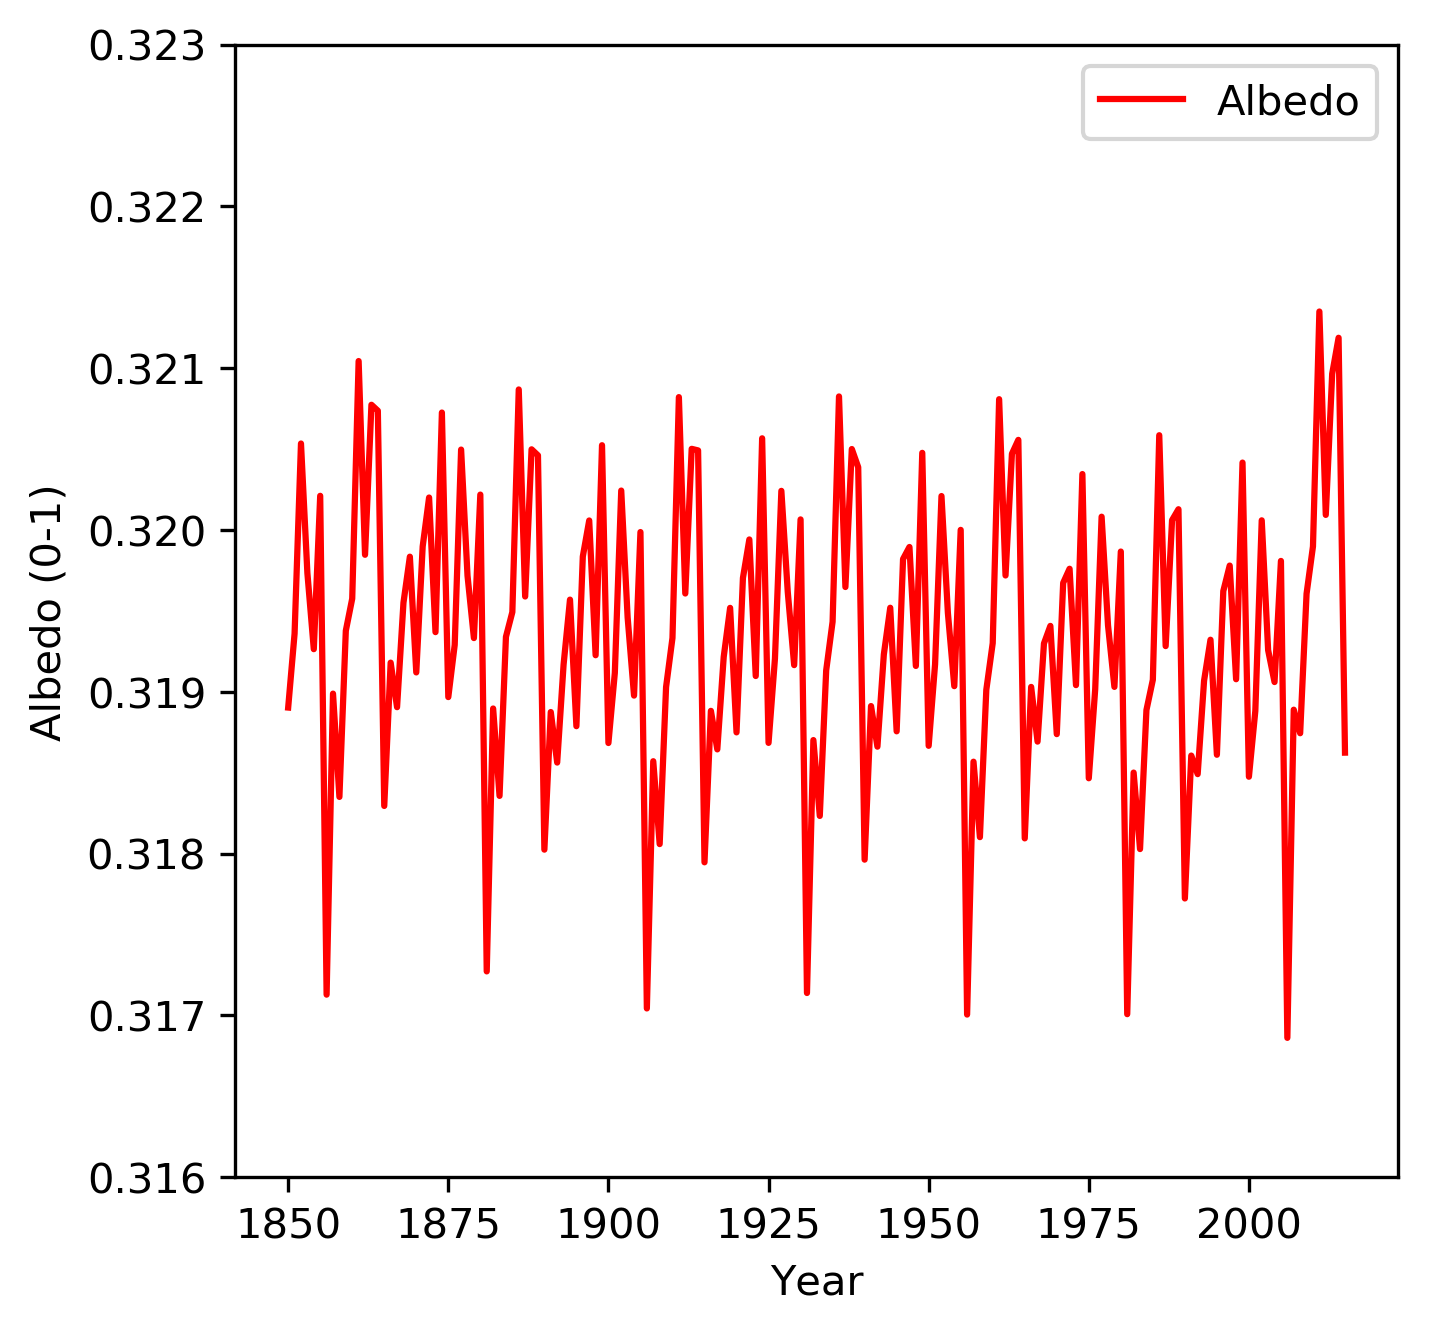

In [21]:
# Time series of albedo
# Can only sort out the impact from logging activity through different experiments
# Calculate the time series of secondary forest area 
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)

alb_map = copy.deepcopy(ref_sr[(nyr*12-nyr):(nyr*12),:,:]/tot_sr[(nyr*12-nyr):(nyr*12),:,:])
for i in np.arange(0,nyr):
    alb_map[i,:,:] = np.mean(ref_sr[(i*12):(i*12+12),:,:], 0)/np.mean(tot_sr[(i*12):(i*12+12),:,:])*area_4x5*land_4x5

# Albedo requires area-weighted mean
alb_global = np.nansum(np.nansum(alb_map, 1), 1) /  np.nansum(area_4x5*land_4x5)

# Plots
plt.plot(yr_axis, alb_global, 'r-')

# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Albedo'])
plt.ylim([0.316,0.323])
plt.xlabel('Year')
plt.ylabel('Albedo (0-1)')
plt.savefig('SEC_ALB_TS.png')

### Explore certain variables: Sensible heat

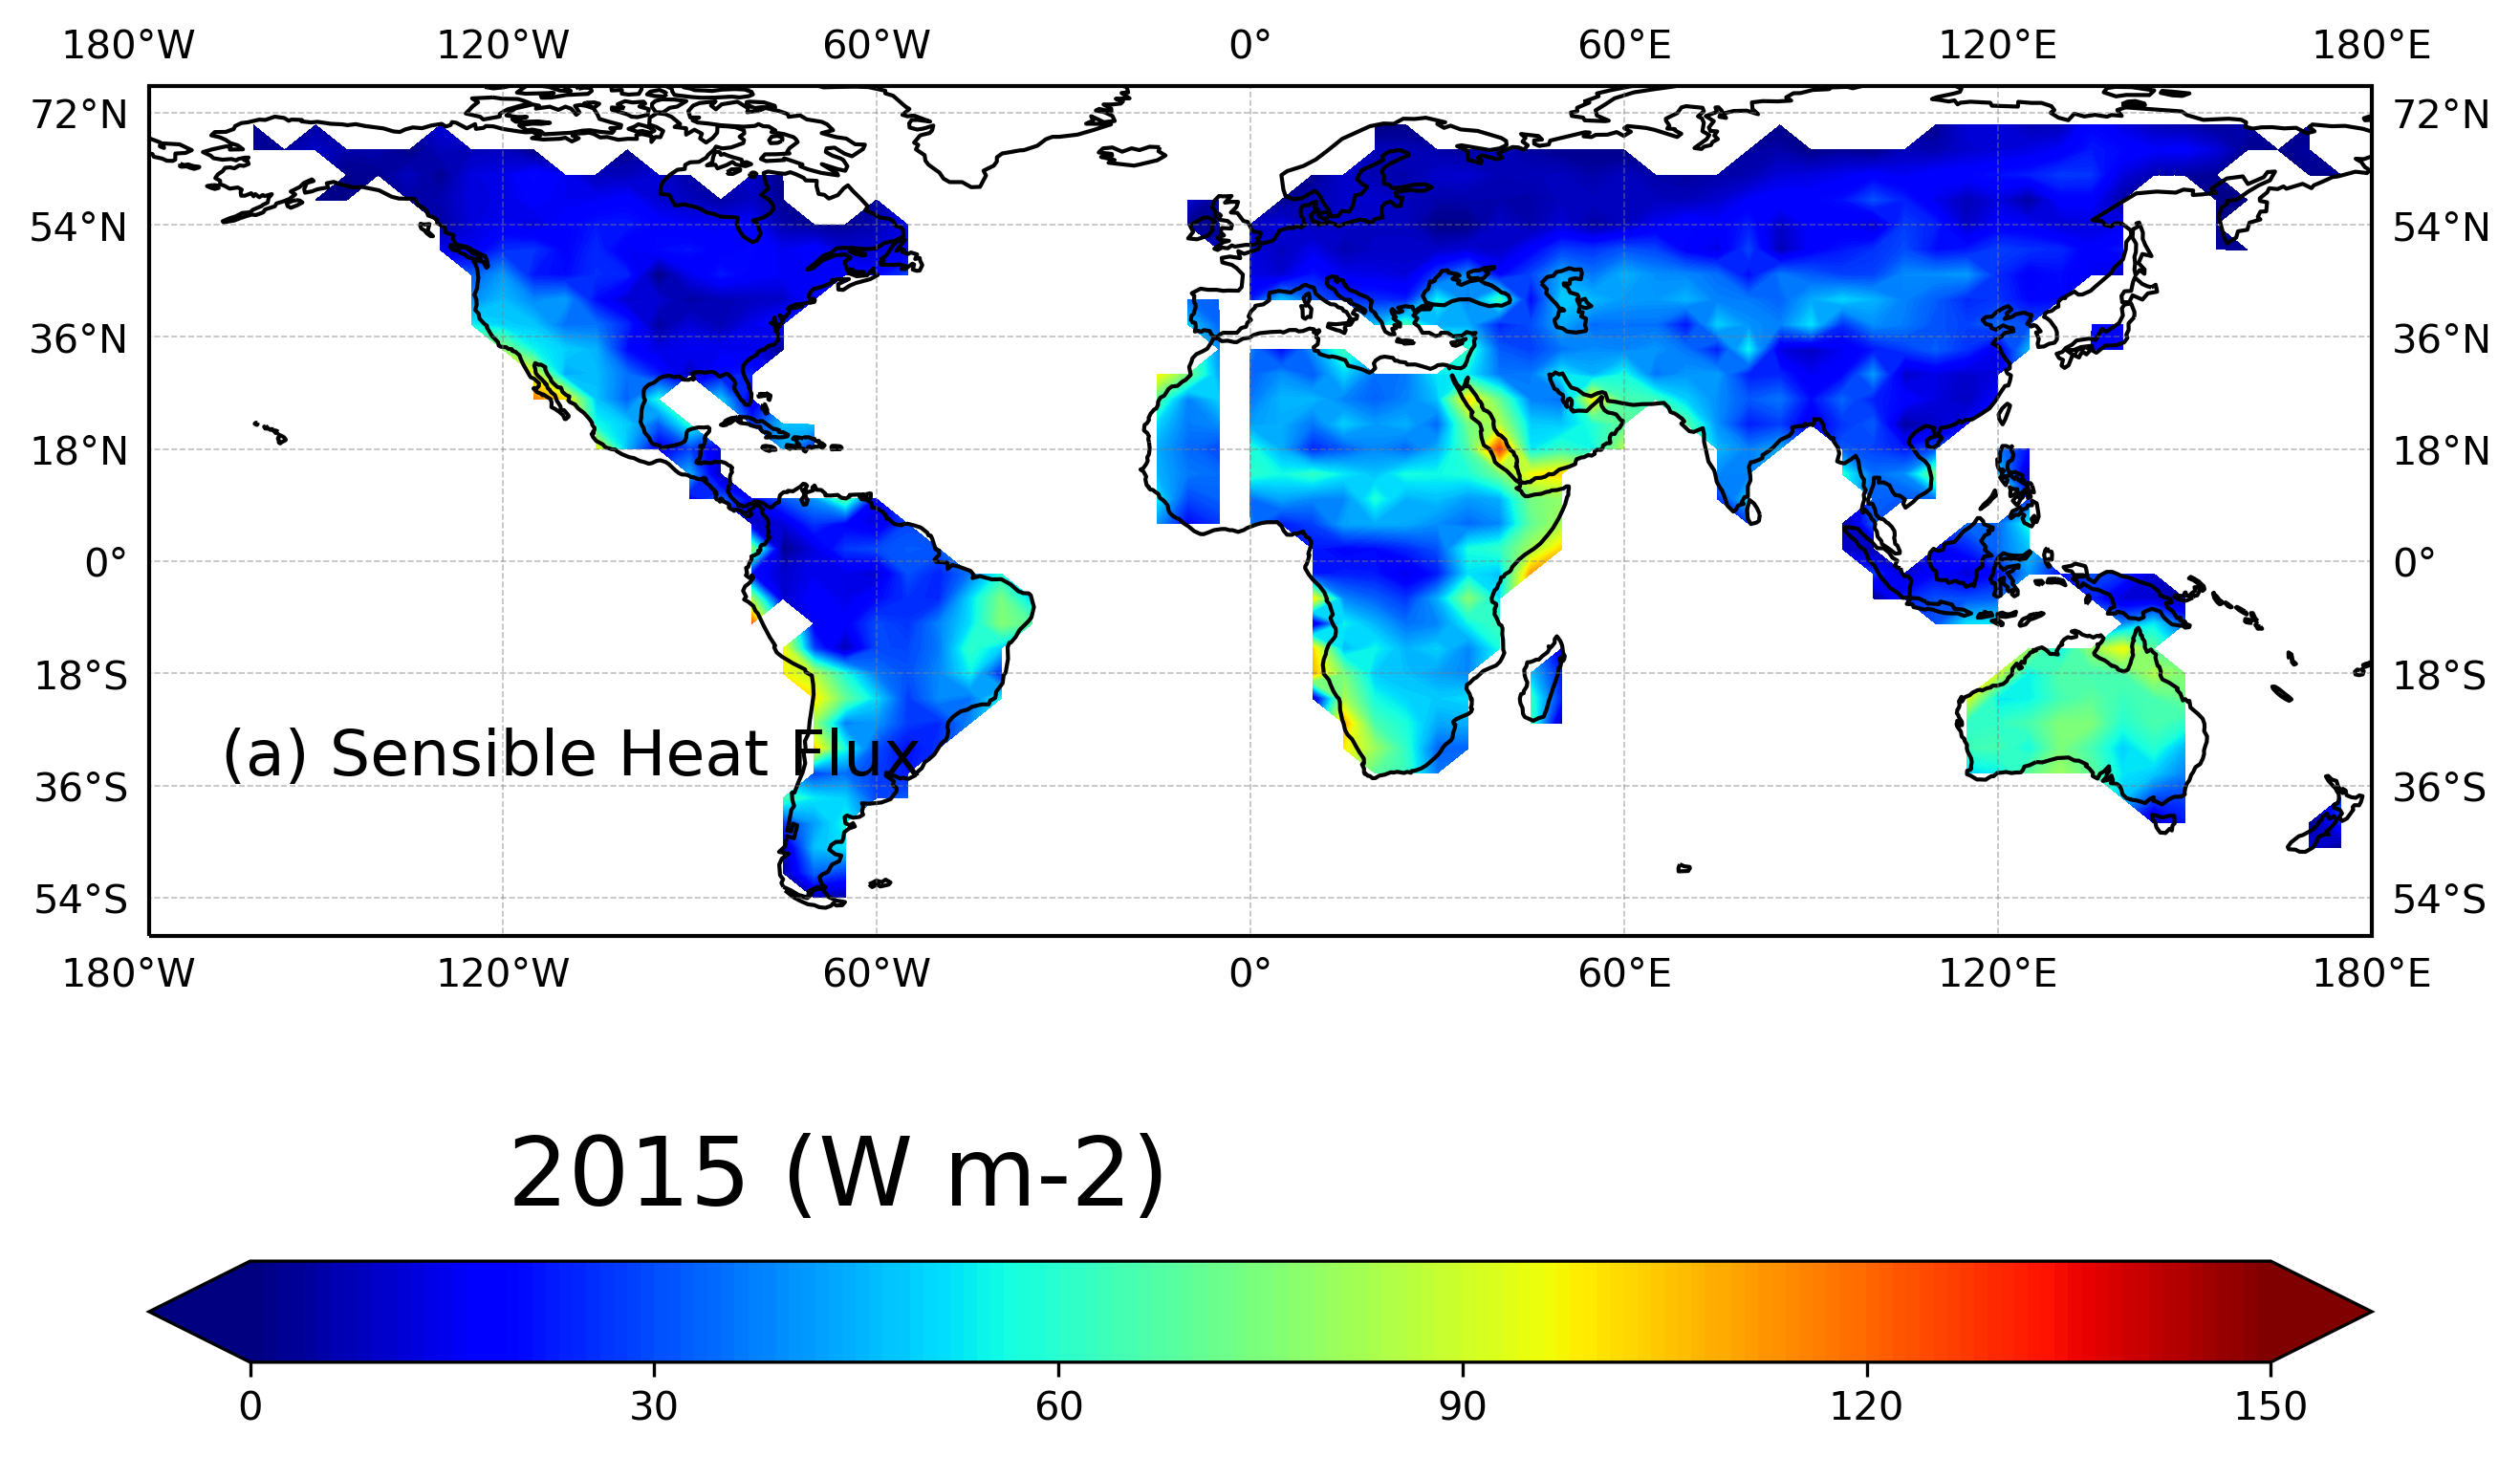

In [30]:
# Check Sensible Heat
fig = plt.figure(figsize=(10,10), dpi=300)
sh = copy.deepcopy(np.mean(tot_sh[(nyr*12-12):(nyr*12),:,:], 0))

sh[sh<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, sh[:,:], 60, levels=np.linspace(0.0, 150.0, 151), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Sensible Heat Flux', fontsize=16)
fig.text(0.25, 0.22, '2015 (W m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 30.0, 60.0, 90.0, 120.0, 150.0] )
plt.savefig('FATES_SH.png')

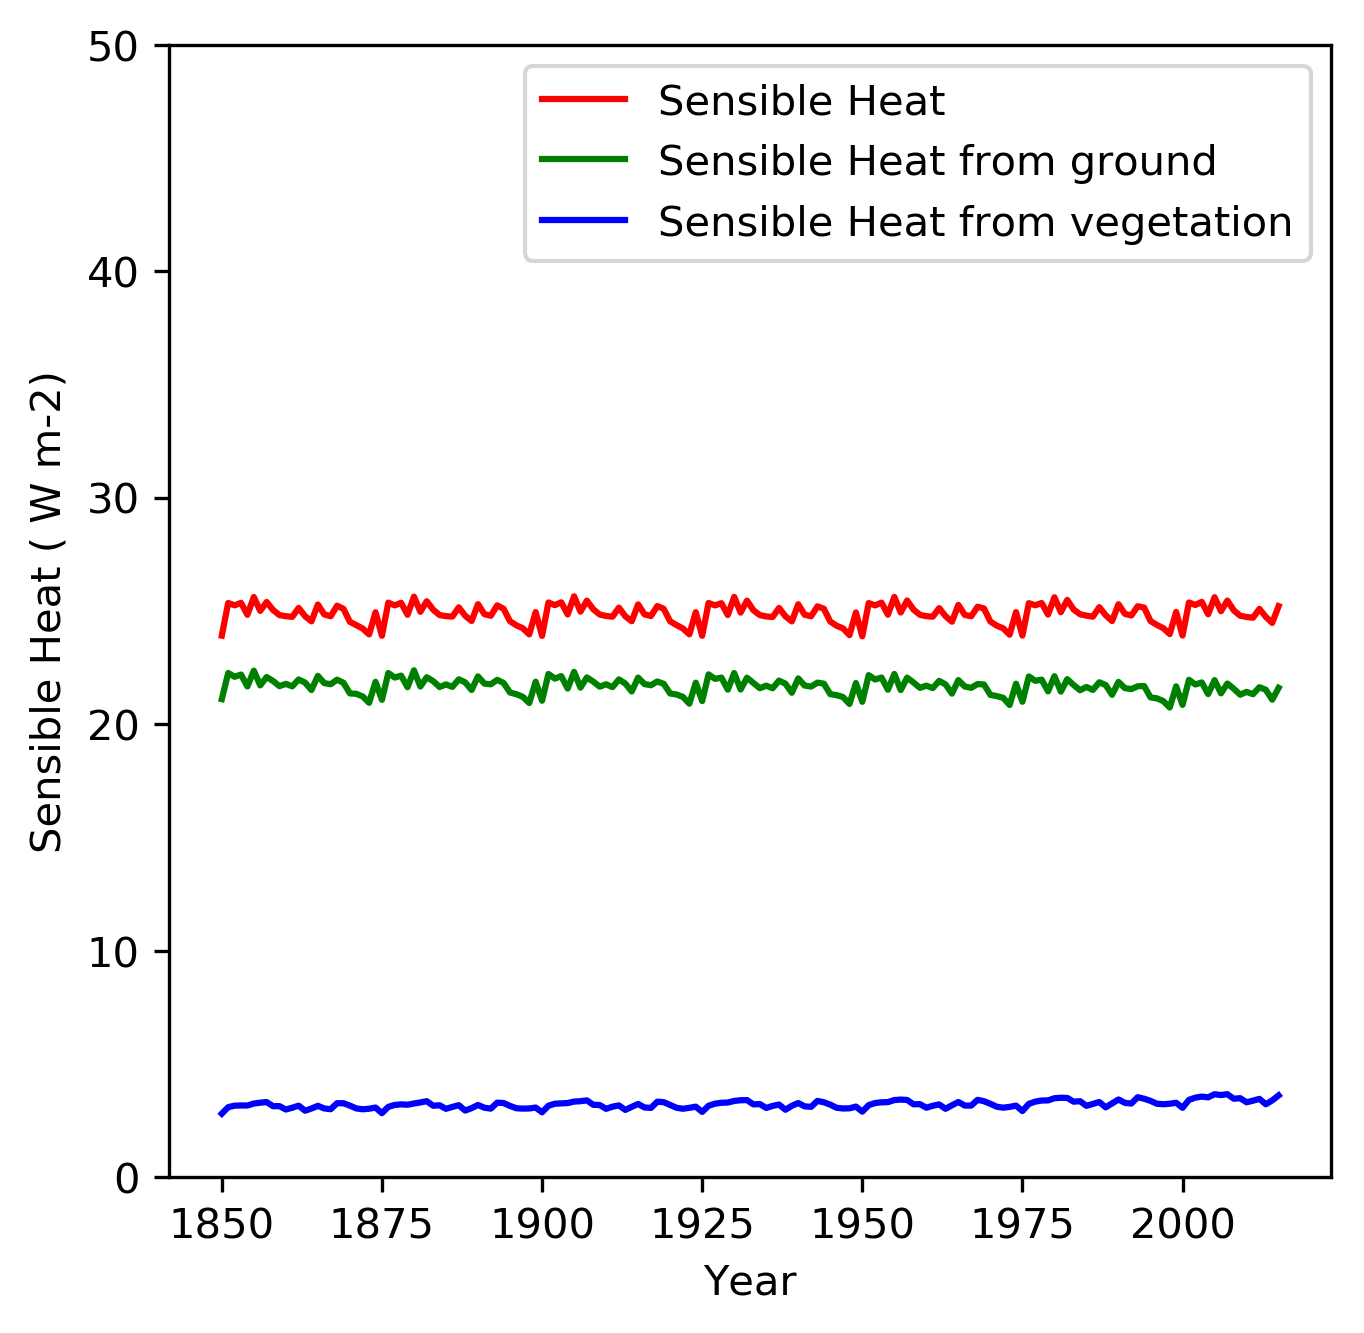

In [51]:
# Time series of SH
# Can only sort out the impact from logging activity through different experiments
# Calculate the time series of secondary forest area 
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)

sh_map = copy.deepcopy(tot_sh[(nyr*12-nyr):(nyr*12),:,:])
shg_map = copy.deepcopy(gro_sh[(nyr*12-nyr):(nyr*12),:,:])
shv_map = copy.deepcopy(veg_sh[(nyr*12-nyr):(nyr*12),:,:])
for i in np.arange(0,nyr):
    sh_map[i,:,:] = np.mean(tot_sh[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    shg_map[i,:,:] = np.mean(gro_sh[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    shv_map[i,:,:] = np.mean(veg_sh[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5

# Albedo requires area-weighted mean
sh_global = np.nansum(np.nansum(sh_map, 1), 1) /  np.nansum(area_4x5*land_4x5)
shg_global = np.nansum(np.nansum(shg_map, 1), 1) /  np.nansum(area_4x5*land_4x5)
shv_global = np.nansum(np.nansum(shv_map, 1), 1) /  np.nansum(area_4x5*land_4x5)

# Plots
plt.plot(yr_axis, sh_global, 'r-')
plt.plot(yr_axis, shg_global, 'g-')
plt.plot(yr_axis, shv_global, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Sensible Heat', 'Sensible Heat from ground', 'Sensible Heat from vegetation'])
plt.ylim([0, 50])
plt.xlabel('Year')
plt.ylabel('Sensible Heat ( W m-2)')
plt.savefig('SEC_SH_TS.png')

### Explore certain variables: Latent heat

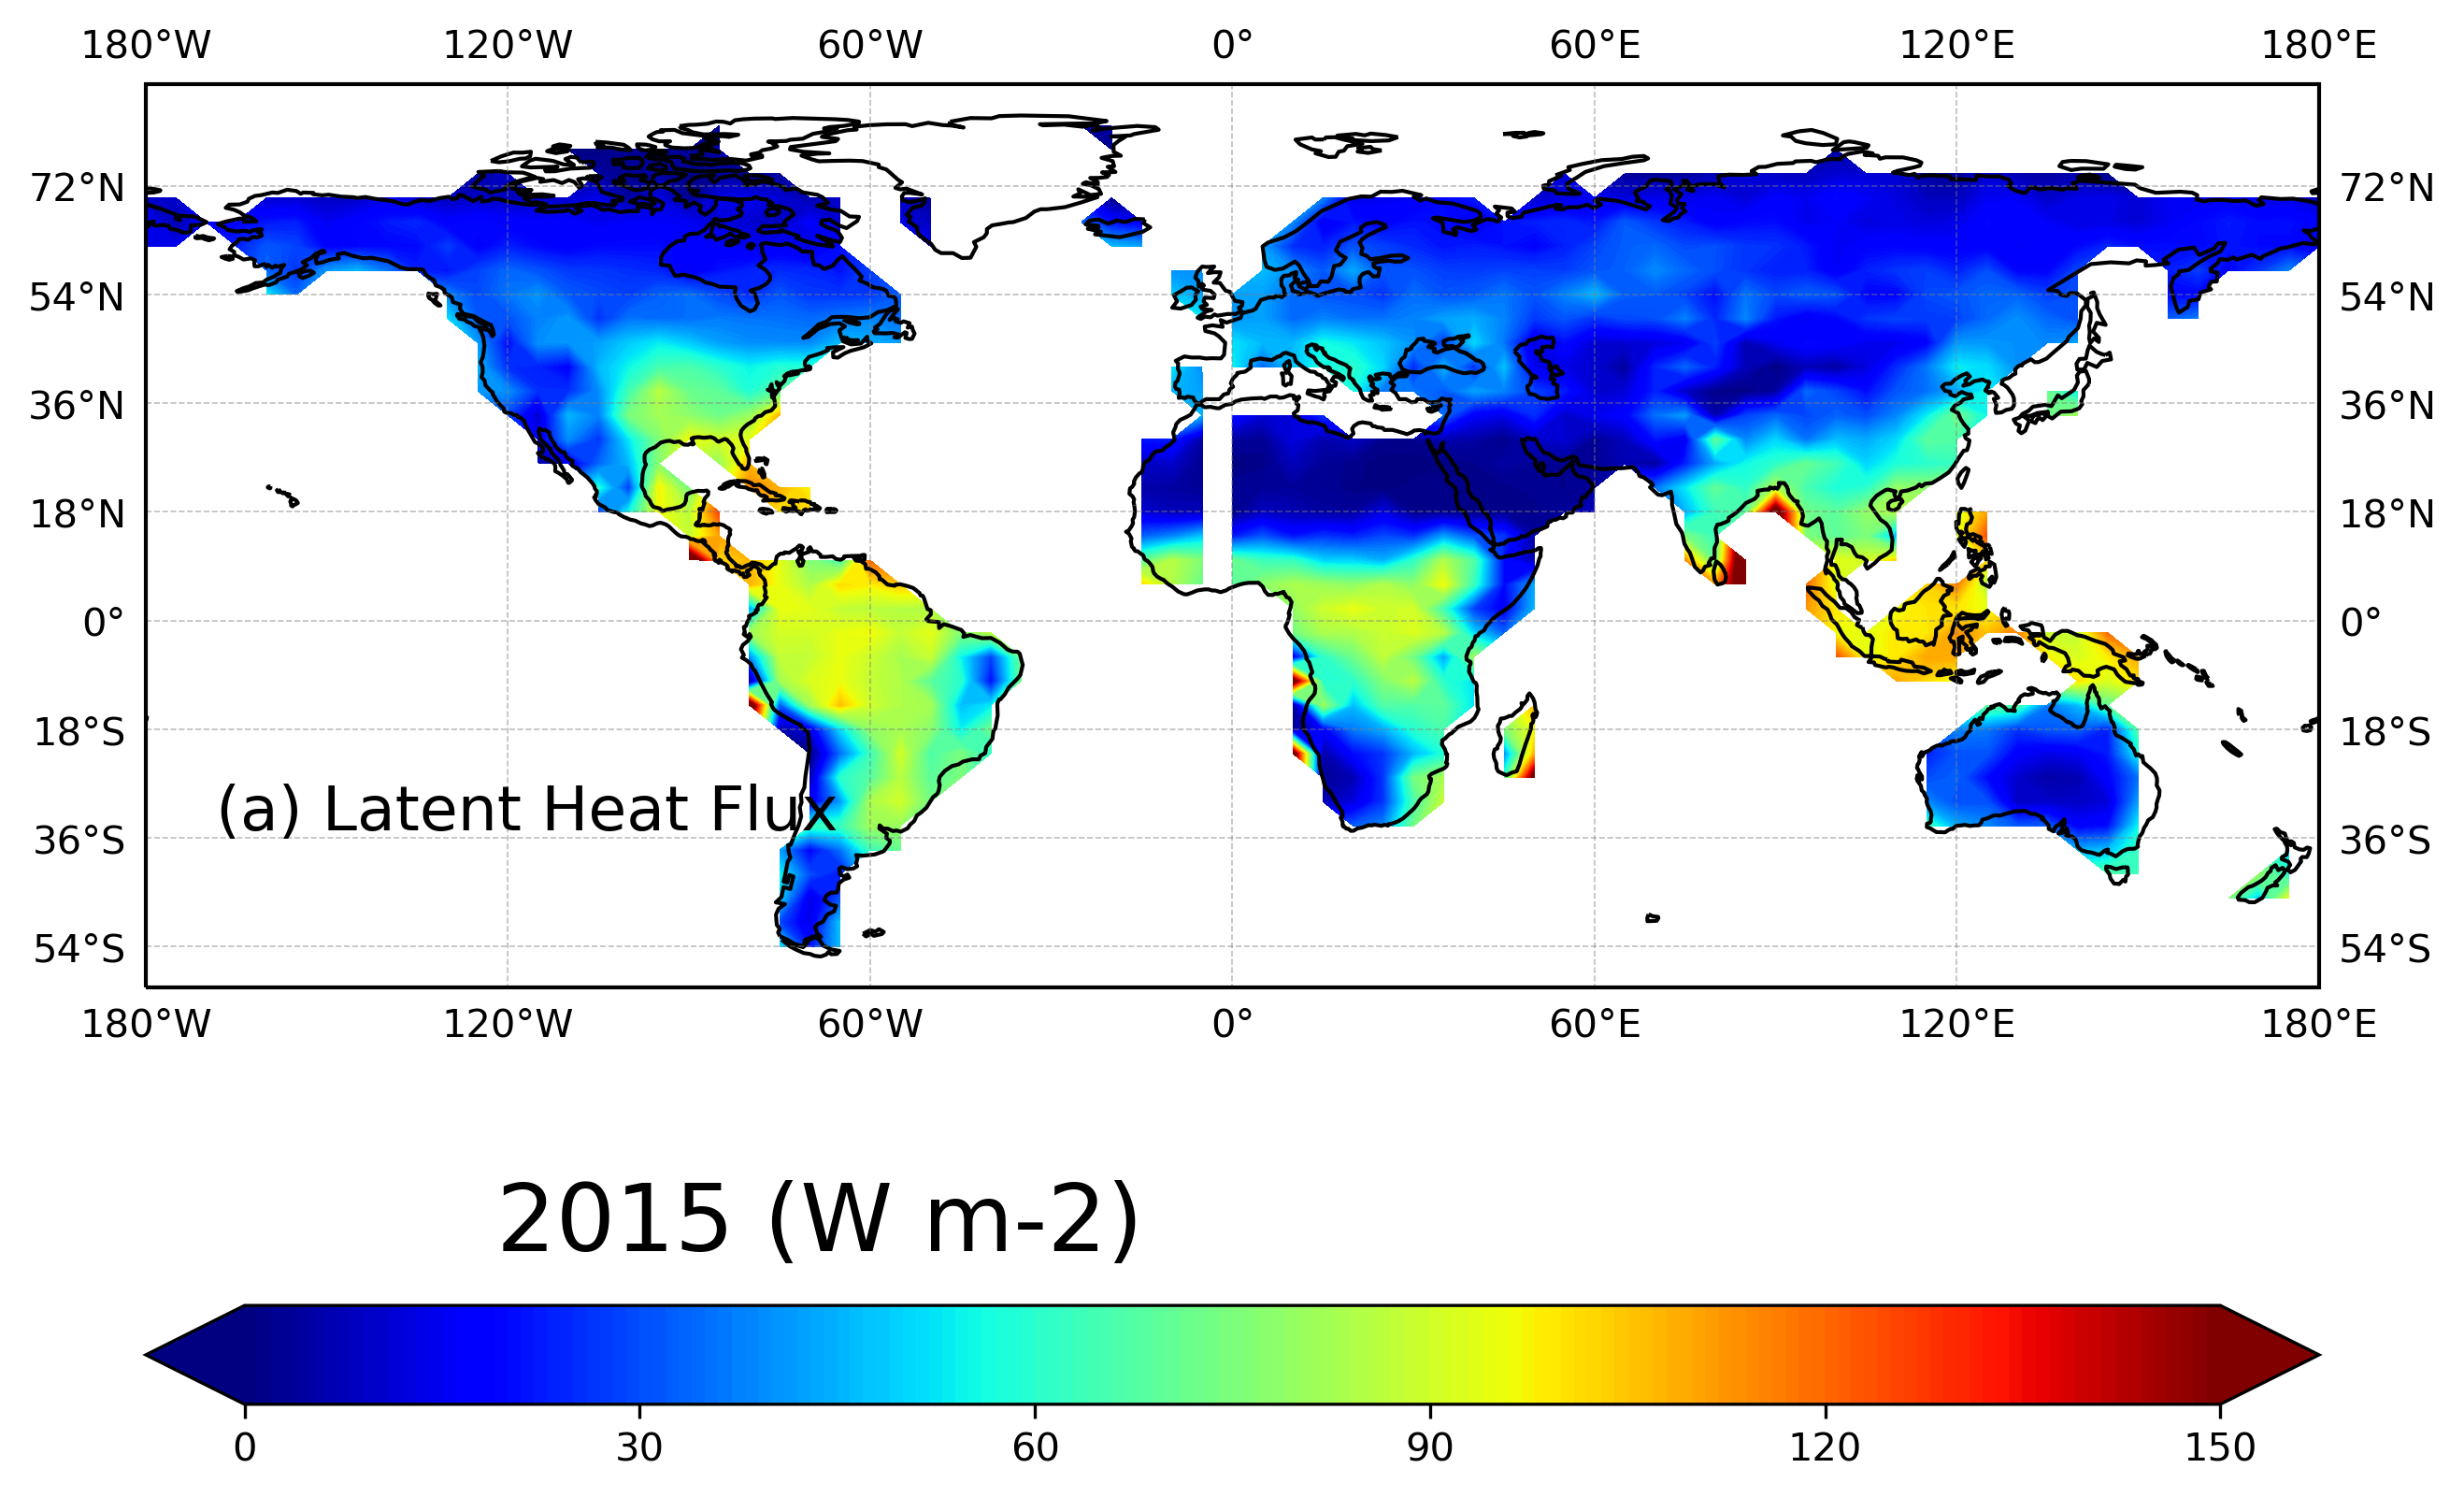

In [34]:
# Check Sensible Heat
fig = plt.figure(figsize=(10,10), dpi=300)
lh = copy.deepcopy(np.mean(tot_lh[(nyr*12-12):(nyr*12),:,:], 0))

lh[lh<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, lh[:,:], 60, levels=np.linspace(0.0, 150.0, 151), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Latent Heat Flux', fontsize=16)
fig.text(0.25, 0.22, '2015 (W m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 30.0, 60.0, 90.0, 120.0, 150.0] )
plt.savefig('FATES_LH.png')


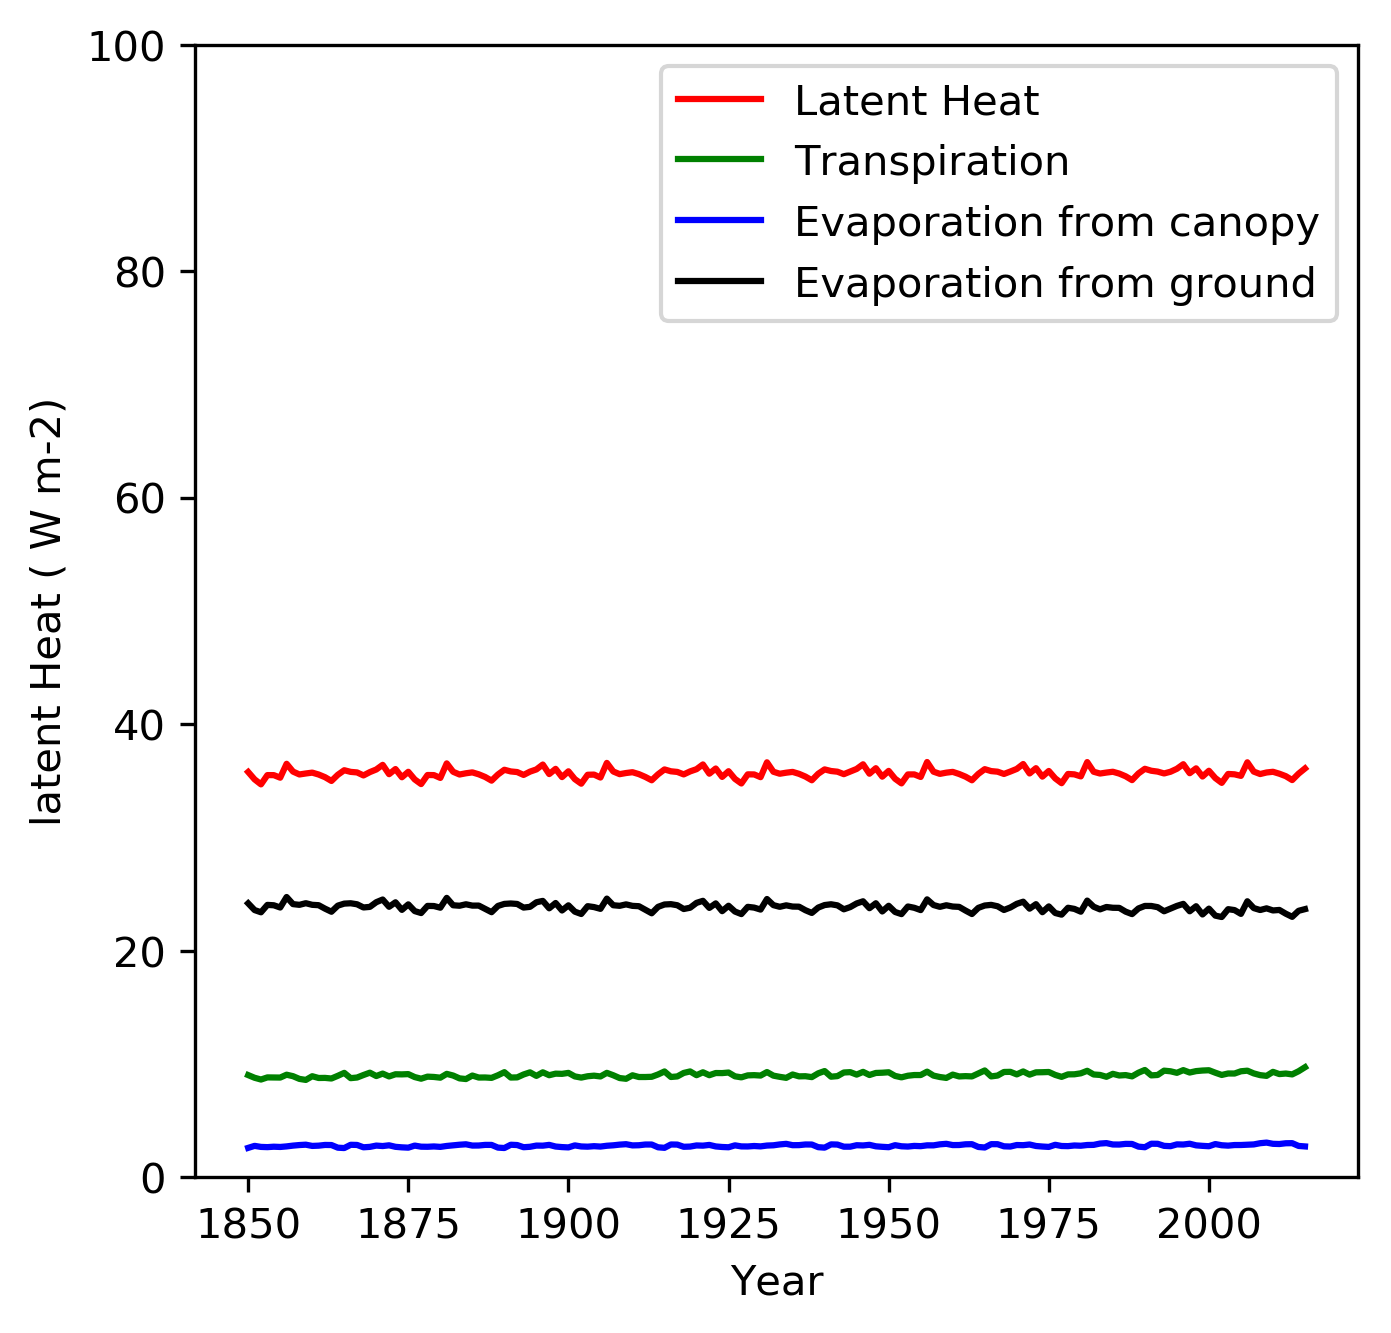

In [52]:
# Time series of LH
# Can only sort out the impact from logging activity through different experiments
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)

lh_map = copy.deepcopy(tot_lh[(nyr*12-nyr):(nyr*12),:,:])
trans_map = copy.deepcopy(trans[(nyr*12-nyr):(nyr*12),:,:])
c_evap_map = copy.deepcopy(c_evap[(nyr*12-nyr):(nyr*12),:,:])
g_evap_map = copy.deepcopy(g_evap[(nyr*12-nyr):(nyr*12),:,:])
for i in np.arange(0,nyr):
    lh_map[i,:,:] = np.mean(tot_lh[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    trans_map[i,:,:] = np.mean(trans[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    c_evap_map[i,:,:] = np.mean(c_evap[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    g_evap_map[i,:,:] = np.mean(g_evap[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5

# Albedo requires area-weighted mean
lh_global = np.nansum(np.nansum(lh_map, 1), 1) /  np.sum(area_4x5*land_4x5)
trans_global = np.nansum(np.nansum(trans_map, 1), 1) /  np.nansum(area_4x5*land_4x5)
c_evap_global = np.nansum(np.nansum(c_evap_map, 1), 1) /  np.nansum(area_4x5*land_4x5)
g_evap_global = np.nansum(np.nansum(g_evap_map, 1), 1) /  np.nansum(area_4x5*land_4x5)

# Plots
plt.plot(yr_axis, lh_global, 'r-')
plt.plot(yr_axis, trans_global, 'g-')
plt.plot(yr_axis, c_evap_global, 'b-')
plt.plot(yr_axis, g_evap_global, 'k-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Latent Heat', 'Transpiration', 'Evaporation from canopy', 'Evaporation from ground'])
plt.ylim([0, 100])
plt.xlabel('Year')
plt.ylabel('latent Heat ( W m-2)')
plt.savefig('SEC_LH_TS.png')

In [46]:
np.shape(land_4x5)

(46L, 72L)

### Explore certain variables: surface roughness

In [47]:
land_4x5

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.00000001],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.36844245, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Backup codes

In [ ]:
# Total forest biomass
# Productivity map
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365


gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.savefig('FATES_albedo_sec.png')

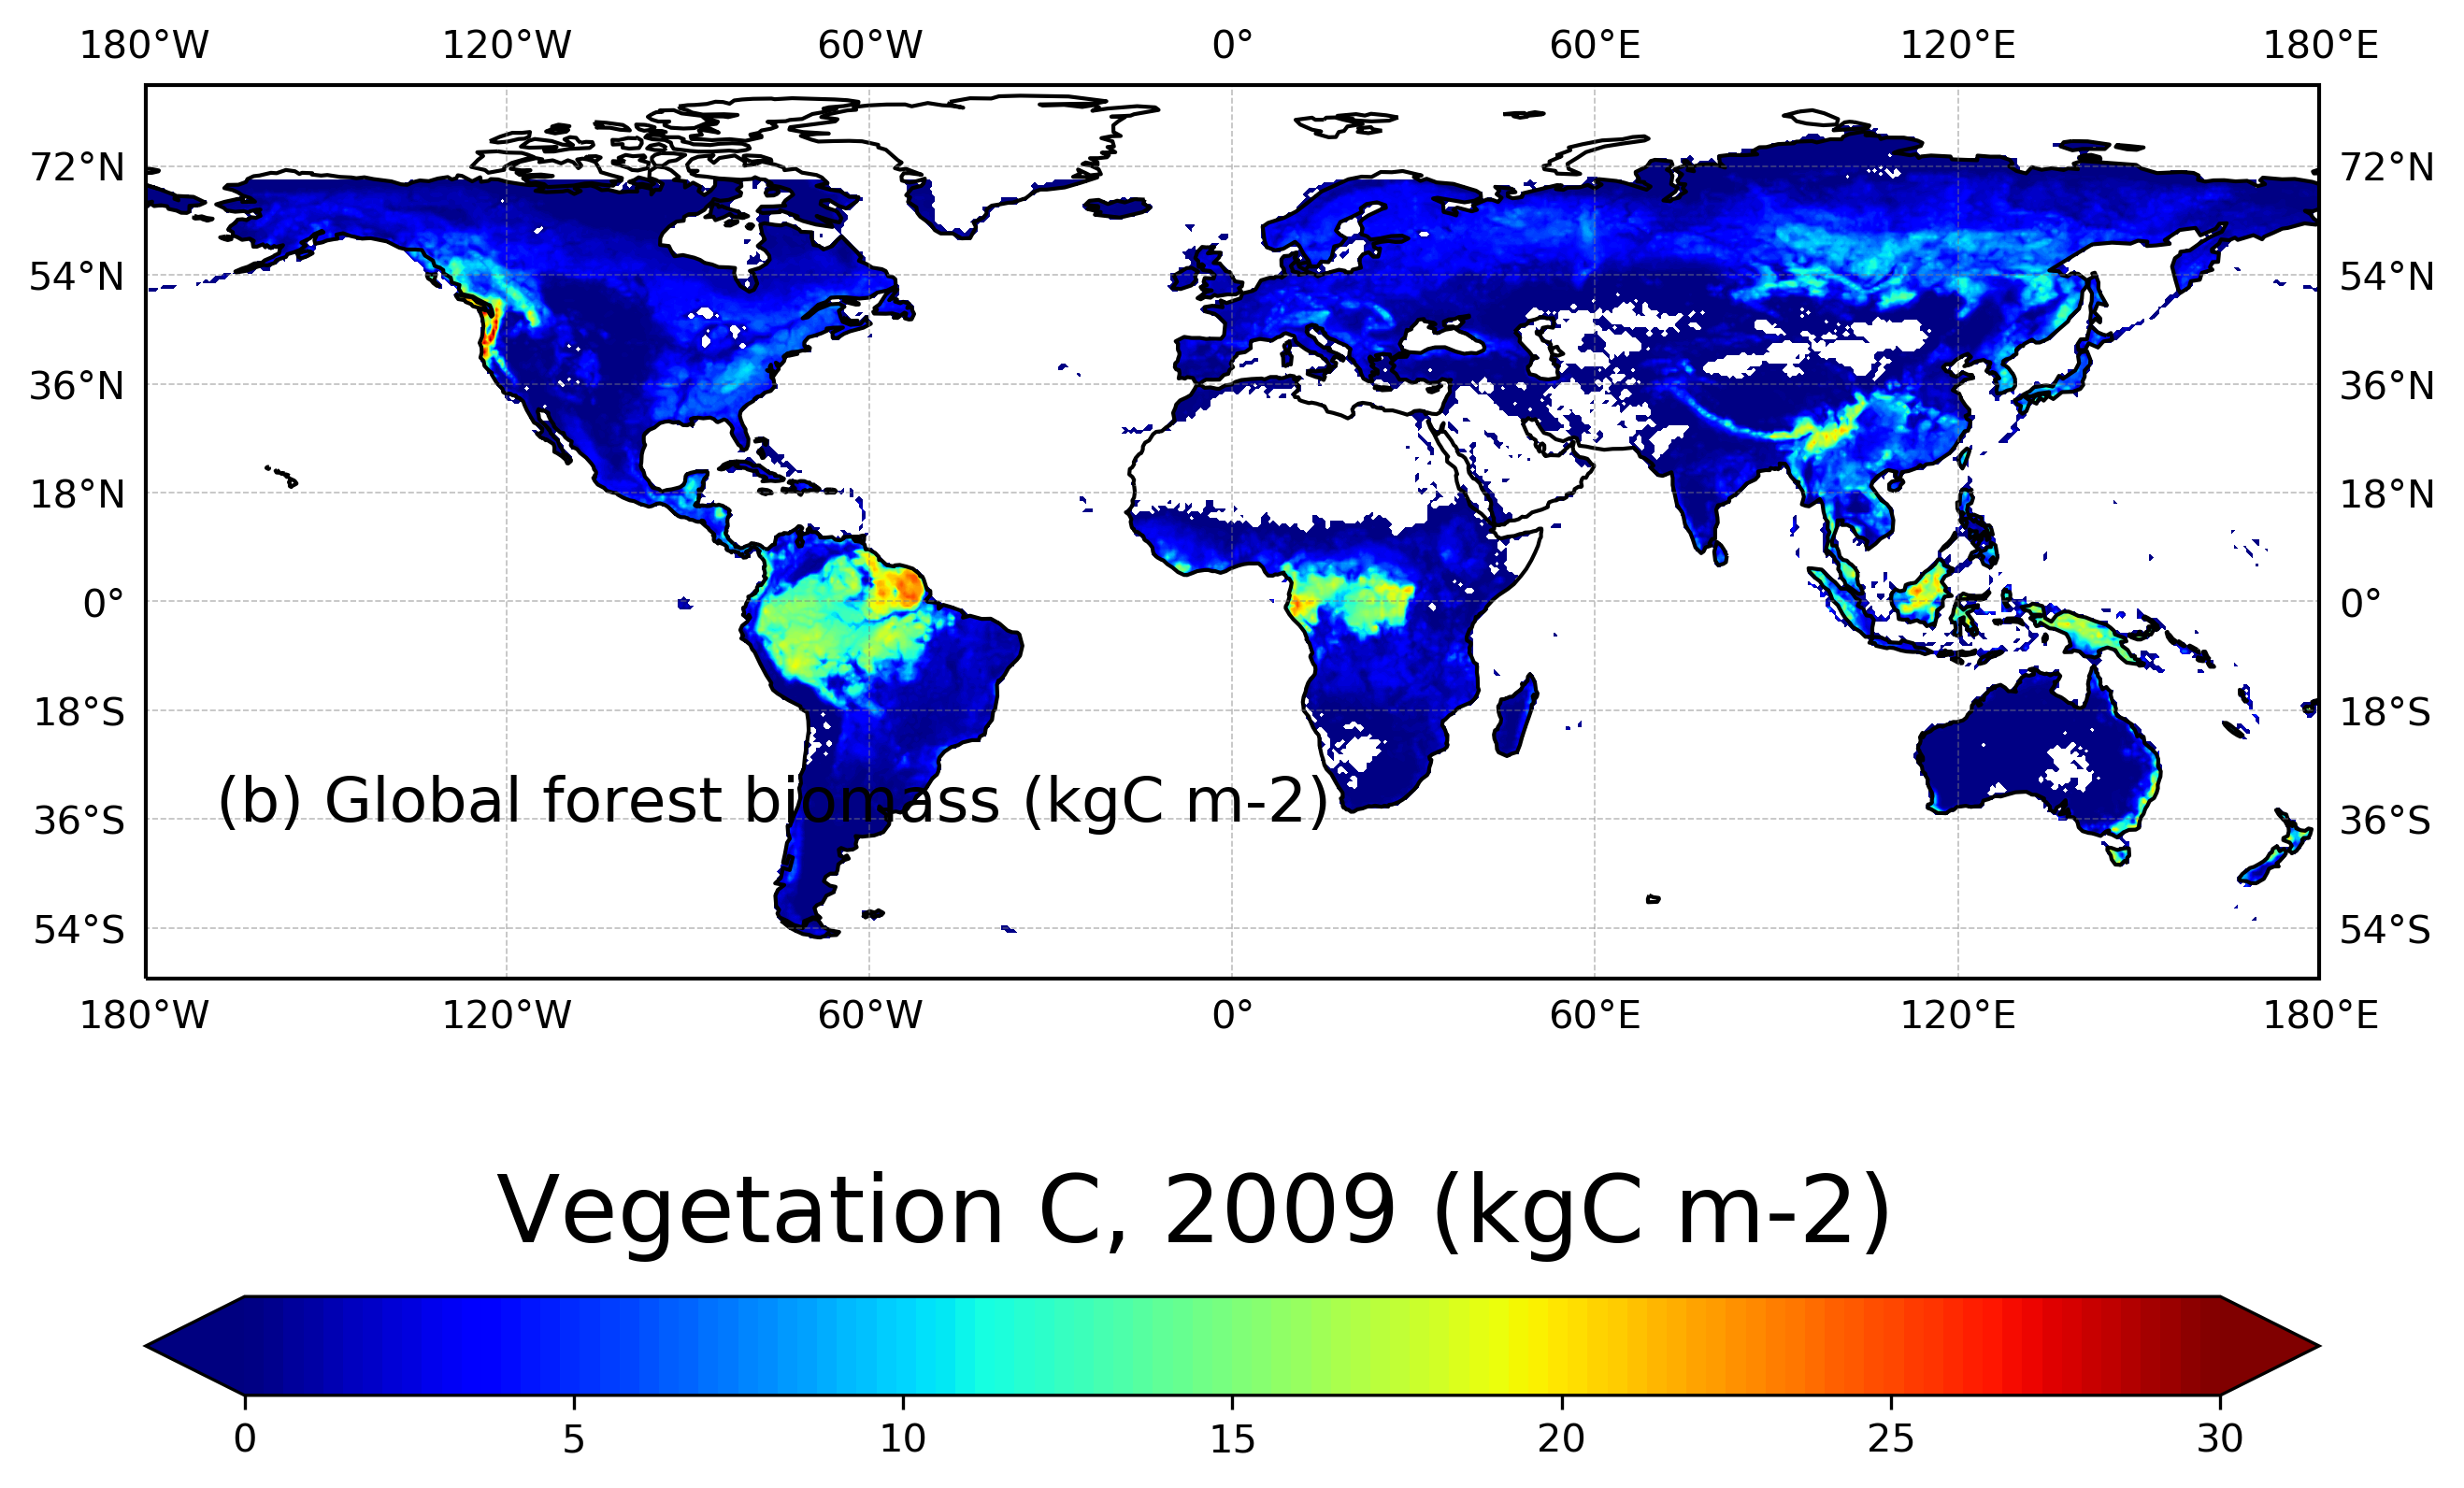

In [41]:
# Comparison to ILAMB products
fig = plt.figure(figsize=(10,10), dpi=300)
gc_for_copy = copy.deepcopy(gc_for_c)

ax = plt.axes(projection=ccrs.PlateCarree())
gc_for_copy[gc_for_copy<0.0] = np.float('nan')
cs = plt.contourf(gc_lon, gc_lat, gc_for_copy[:,:], 60, levels=np.linspace(0.0, 30.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(b) Global Carbon (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'Vegetation C, 2009 (kgC m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0] )
plt.show()


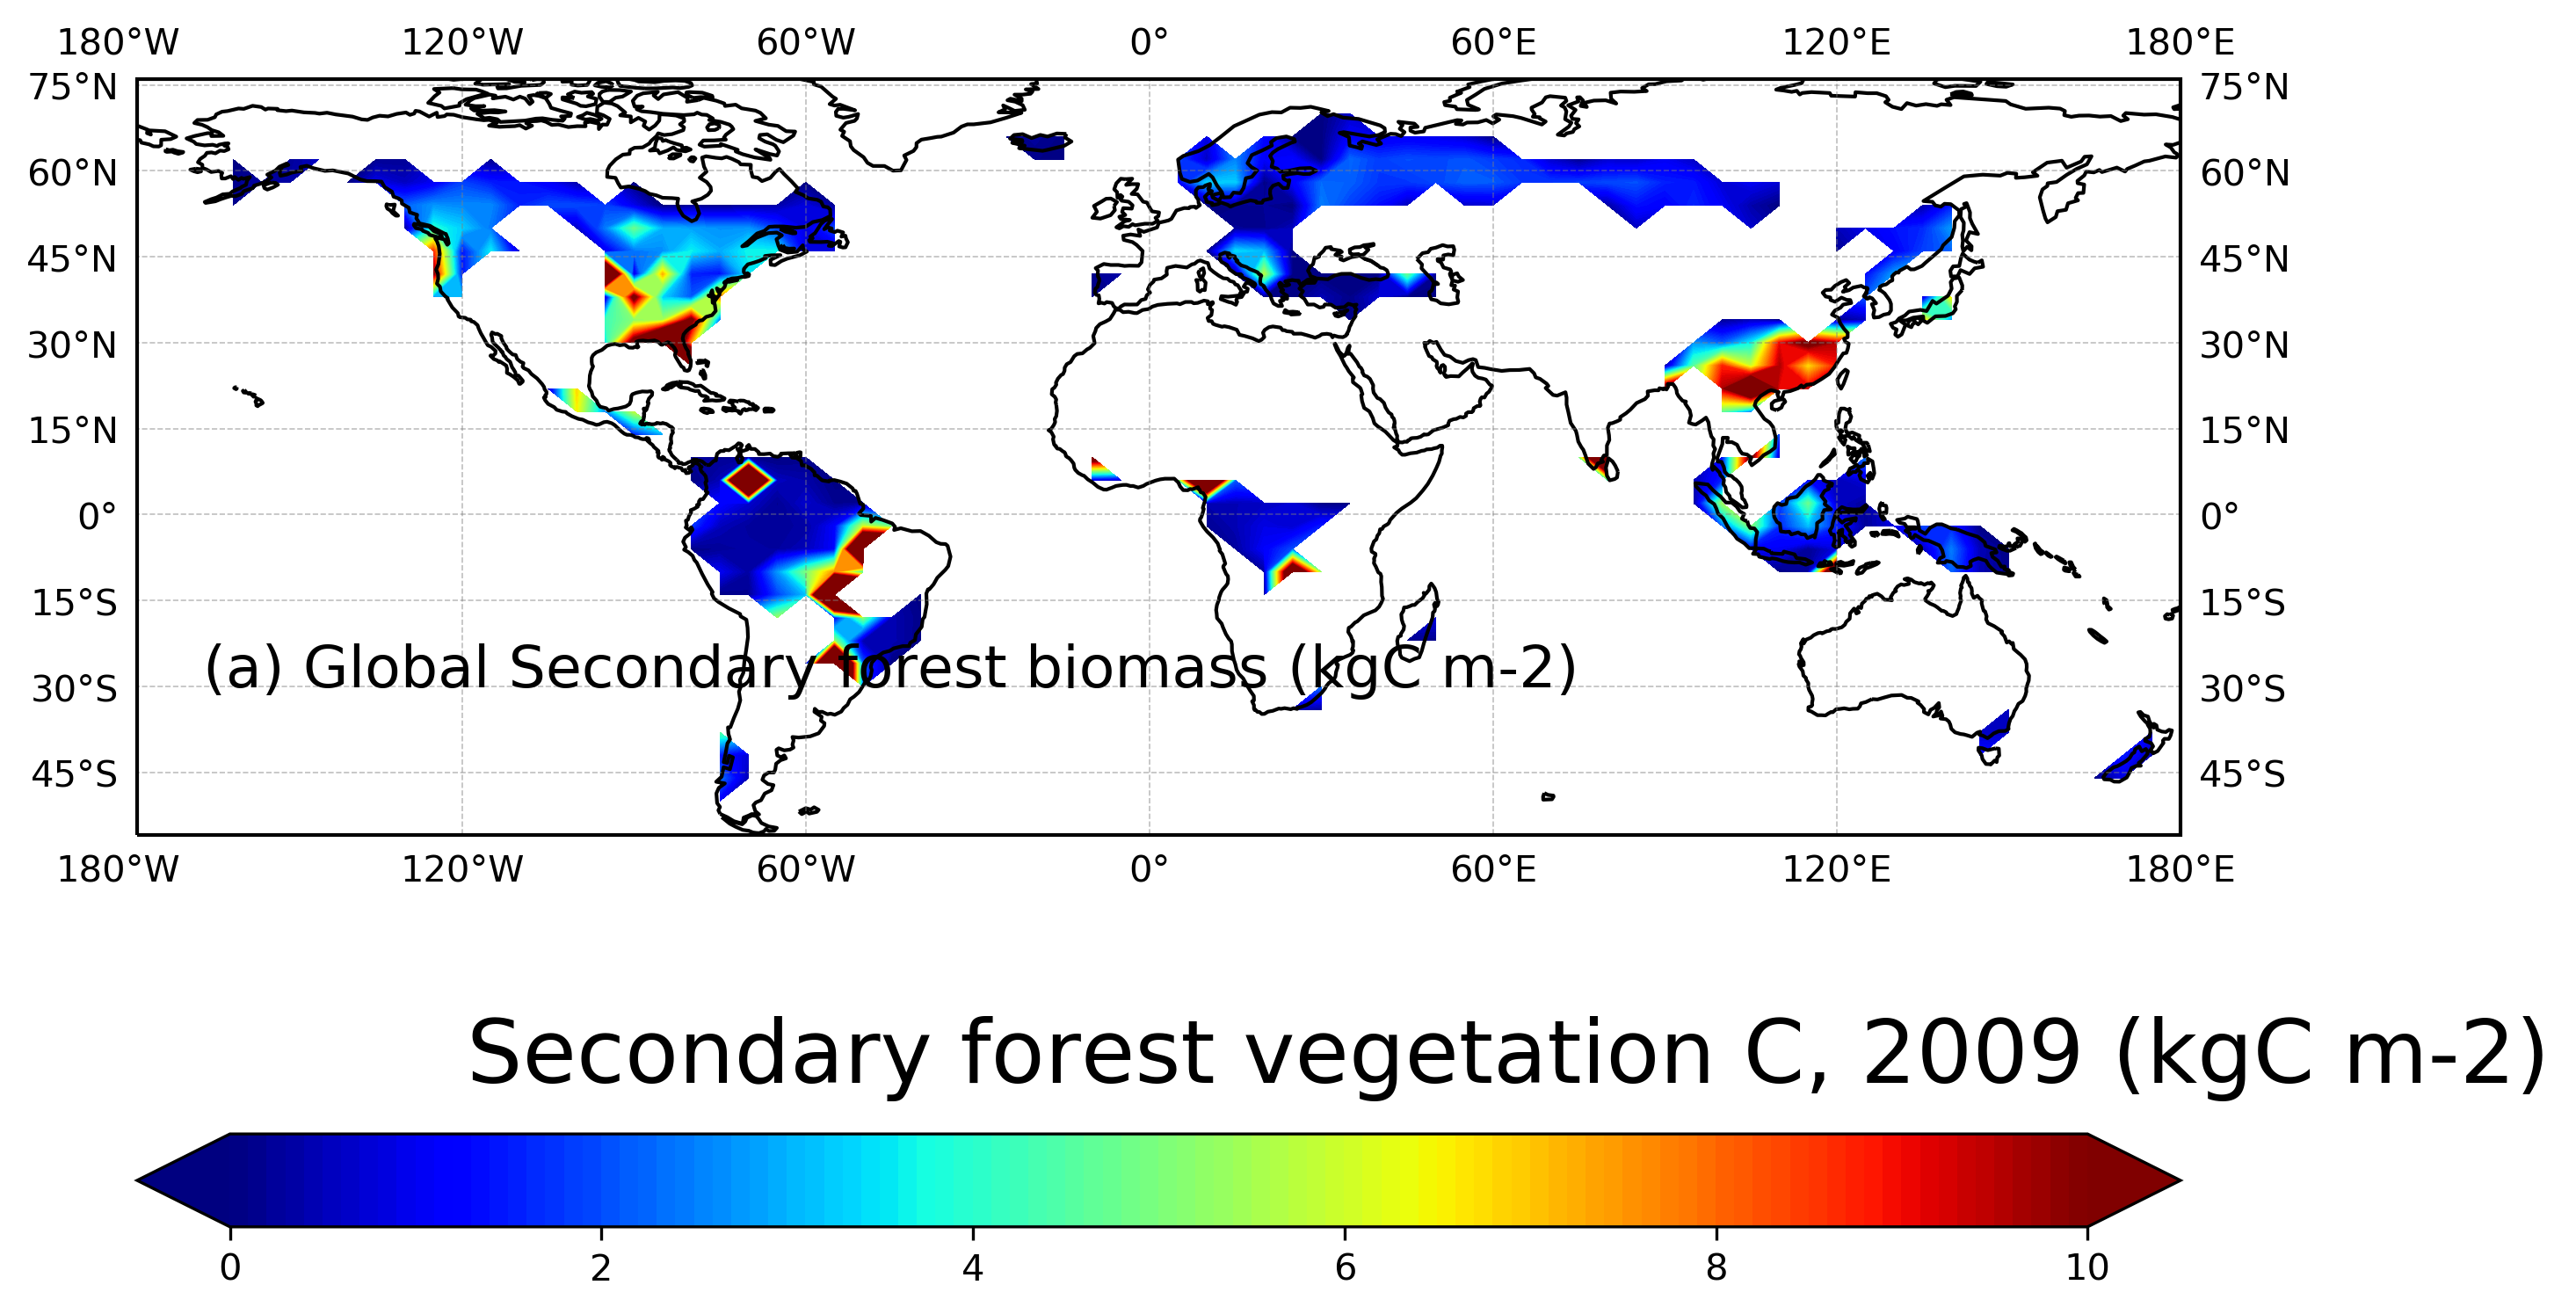

In [28]:
# Secondary forest biomass map
fig = plt.figure(figsize=(10,10), dpi=300)
sec_for = copy.deepcopy(np.sum(sec_biomass[nyr*12-1,:,:,:], 0))

sec_for[sec_for<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, sec_for[:,:], 60, levels=np.linspace(0.0, 10.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global Secondary forest biomass (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest vegetation C, 2009 (kgC m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 2.0, 4.0, 6.0, 8.0, 10.0] )
plt.show()
#plt.savefig('SEC_VEGFRAC.png')

In [55]:
np.shape(gpp_new)

(46L, 72L)

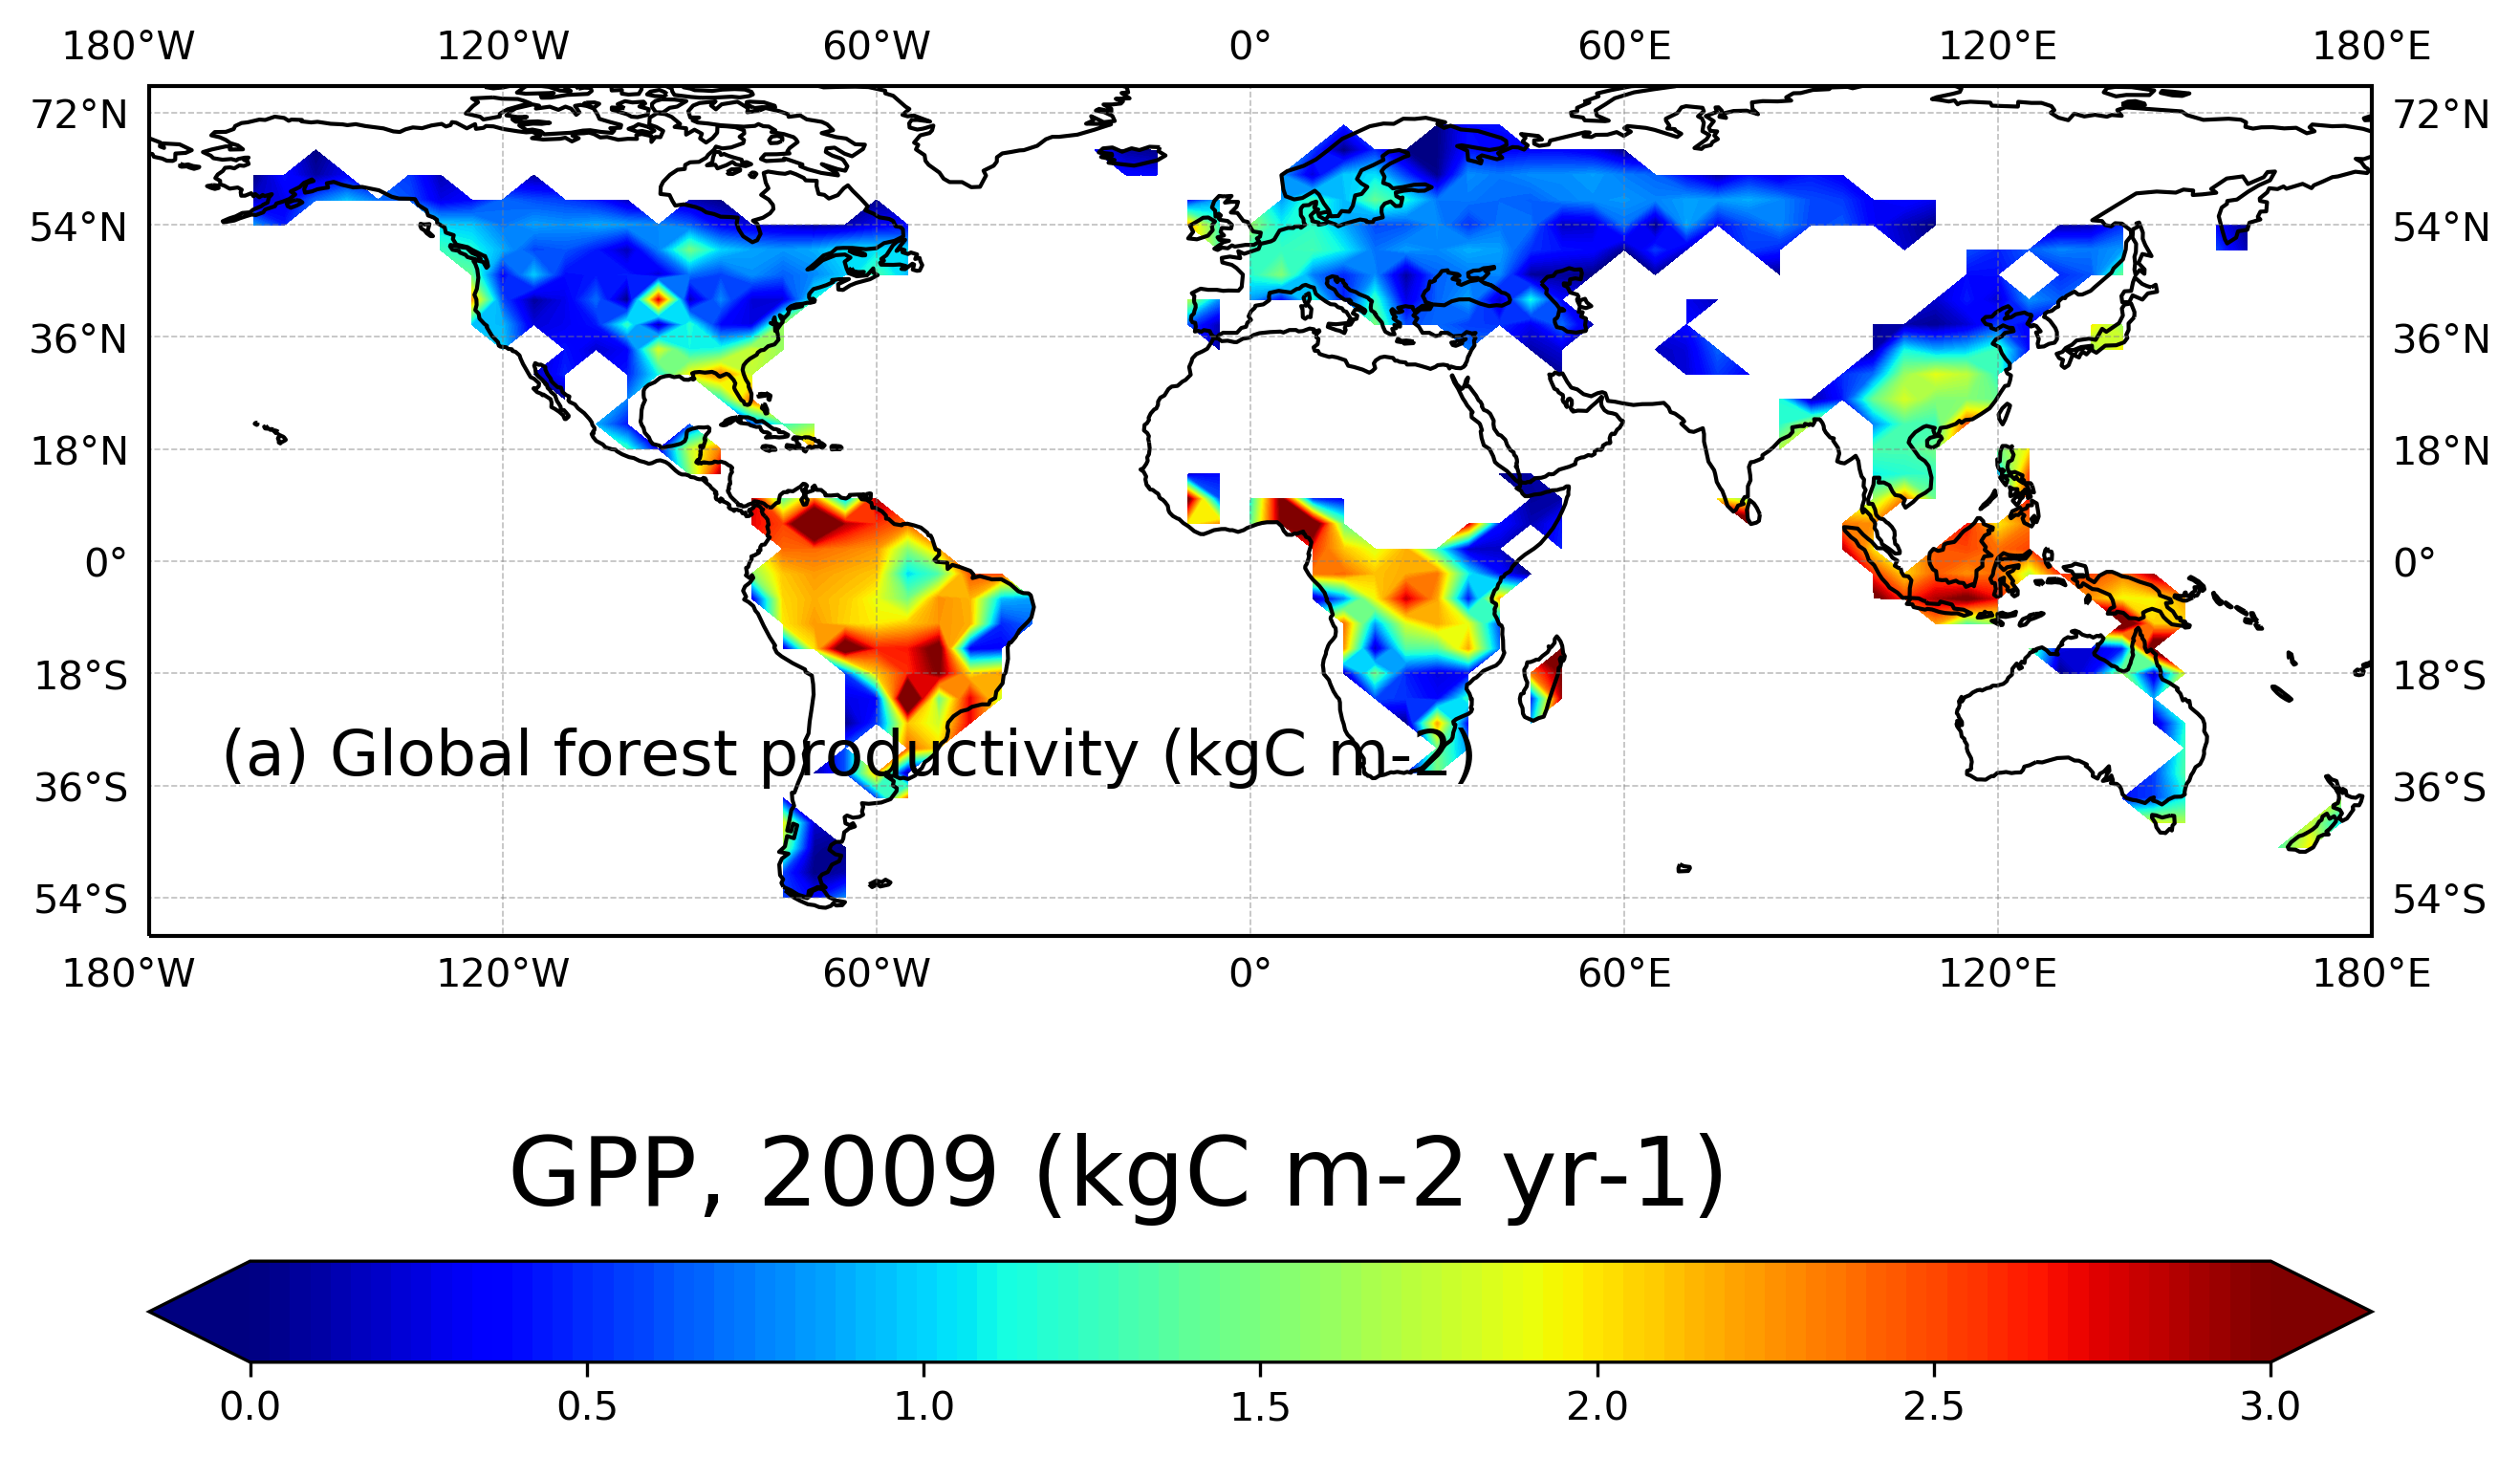

In [64]:
# Productivity map
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365


gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.show()

In [62]:
# Calculate global total
# Secondary forest area requires calculation from multiple years
tot_len = nyr
tot_sec_area = np.zeros((tot_len))
tot_sec_luh2 = np.zeros((tot_len))
tot_hrv_fates = np.zeros((tot_len))
tot_hrv_luh2 = np.zeros((tot_len))
for iyr in np.arange(0,nyr):
    sec_area = sec_frac[12*(iyr+1)-1,:,:]*area_4x5*land_4x5
    tot_sec_area[iyr] = np.nansum(np.nansum(sec_area, 0), 0)
    sec_luh2 = secf_luh2[999+iyr,:,:]*grid_area*1e-6
    tot_sec_luh2[iyr] = np.nansum(np.nansum(sec_luh2, 0), 0)
    hrv_map = np.nanmean(hrv10flux[(12*iyr):(12*(iyr+1)-1),:,:]+hrv100flux[(12*iyr):(12*(iyr+1)-1),:,:], 0)* \
        area_4x5*land_4x5*1e6*1e-3*24*3600*365
    tot_hrv_fates[iyr] = np.nansum(np.nansum(hrv_map, 0), 0)
    hrv_luh2 = primf_bioh[999+iyr,:,:] + primn_bioh[999+iyr,:,:]
    tot_hrv_luh2[iyr] = np.nansum(np.nansum(hrv_luh2, 0), 0)

# Check the whole time series 
soilc_copy = copy.deepcopy(soilc[:,:,:])
vegc_copy = copy.deepcopy(vegc[:,:,:])
forc_copy = copy.deepcopy(np.sum(vegc_pf[:,0:9,:,:], 1))
litterc_copy = copy.deepcopy(litterc[:,:,:])
structc_copy = copy.deepcopy(structc[:,:,:])
nonstructc_copy = copy.deepcopy(nonstructc[:,:,:])
leafc_copy = copy.deepcopy(leafc[:,:,:])

gpp_copy = copy.deepcopy(gpp[:,:,:])
npp_copy = copy.deepcopy(npp[:,:,:])
hr_copy = copy.deepcopy(hr[:,:,:])
# nbp_copy = copy.deepcopy(nbp[:,:,:])
nep_copy = copy.deepcopy(nep[:,:,:])
litc_in_copy = copy.deepcopy(litc_in[:,:,:])
litc_out_copy = copy.deepcopy(litc_out[:,:,:])

tot_len = nyr*12
tot_soilc = np.zeros((tot_len))
tot_vegc = np.zeros((tot_len))
tot_forc = np.zeros((tot_len))
tot_litterc = np.zeros((tot_len))
tot_structc = np.zeros((tot_len))
tot_nonstructc = np.zeros((tot_len))
tot_leafc = np.zeros((tot_len))
tot_gpp = np.zeros((tot_len))
tot_npp = np.zeros((tot_len))
tot_nep = np.zeros((tot_len))
# tot_nbp = np.zeros((tot_len))
tot_hr = np.zeros((tot_len))
tot_litc_in = np.zeros((tot_len))
tot_litc_out = np.zeros((tot_len))

for i in np.arange(0, tot_len):
    # Mask can only applied to each 2D slice
    tmp = soilc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_soilc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = vegc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_vegc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = forc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_forc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = litterc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litterc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = structc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_structc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12

    tmp = nonstructc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nonstructc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = leafc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_leafc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = gpp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_gpp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = npp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_npp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = nep_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nep[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12

#     tmp = nbp_copy[i,:,:]
#     tmp[land_4x5<=0] = np.float('nan')
#     tmp[tmp>1e10] = np.float('nan')
#     tot_nbp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e15
    
    tmp = hr_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_hr[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_in_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_in[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_out_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_out[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2

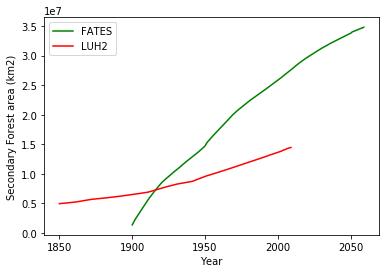

In [93]:
# Line plot to show: Comparison between land cover forcing dataset and secondary forest fraction
plt.plot(np.arange(1850,1850+nyr), tot_sec_area, 'g-')
plt.plot(np.arange(1850,1850+nyr), tot_sec_luh2, 'r-')
plt.legend(['FATES', 'LUH2'])
plt.xlabel('Year')
plt.ylabel('Secondary Forest area (km2)')
# plt.ylim([0, 2e7])
plt.savefig('Sec_area.png')

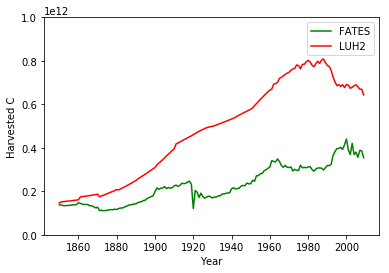

In [25]:
# Line plot to show: Comparison between land cover forcing dataset and harvested C
plt.plot(np.arange(1850,1850+nyr), tot_hrv_fates, 'g-')
plt.plot(np.arange(1850,1850+nyr), tot_hrv_luh2, 'r-')
plt.legend(['FATES', 'LUH2'])
plt.xlabel('Year')
plt.ylabel('Harvested C')
plt.ylim([0, 1e12])
plt.savefig('Harvested_C_curve.png')

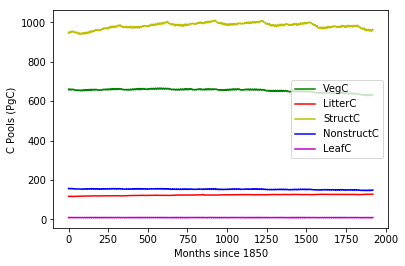

In [95]:
# Line plot of other major C fluxes
# Veg C composition
# plt.plot(tot_soilc, 'k-')
plt.plot(tot_forc, 'g-')
plt.plot(tot_litterc, 'r-')
plt.plot(tot_structc, 'y-')
plt.plot(tot_nonstructc, 'b-')
plt.plot(tot_leafc, 'm-')
plt.legend(['VegC', 'LitterC', 'StructC', 'NonstructC', 'LeafC'])
plt.xlabel('Months since 1850')
plt.ylabel('C Pools (PgC)')
# plt.ylim([0, 400])
plt.savefig('Major_C_pools.png')

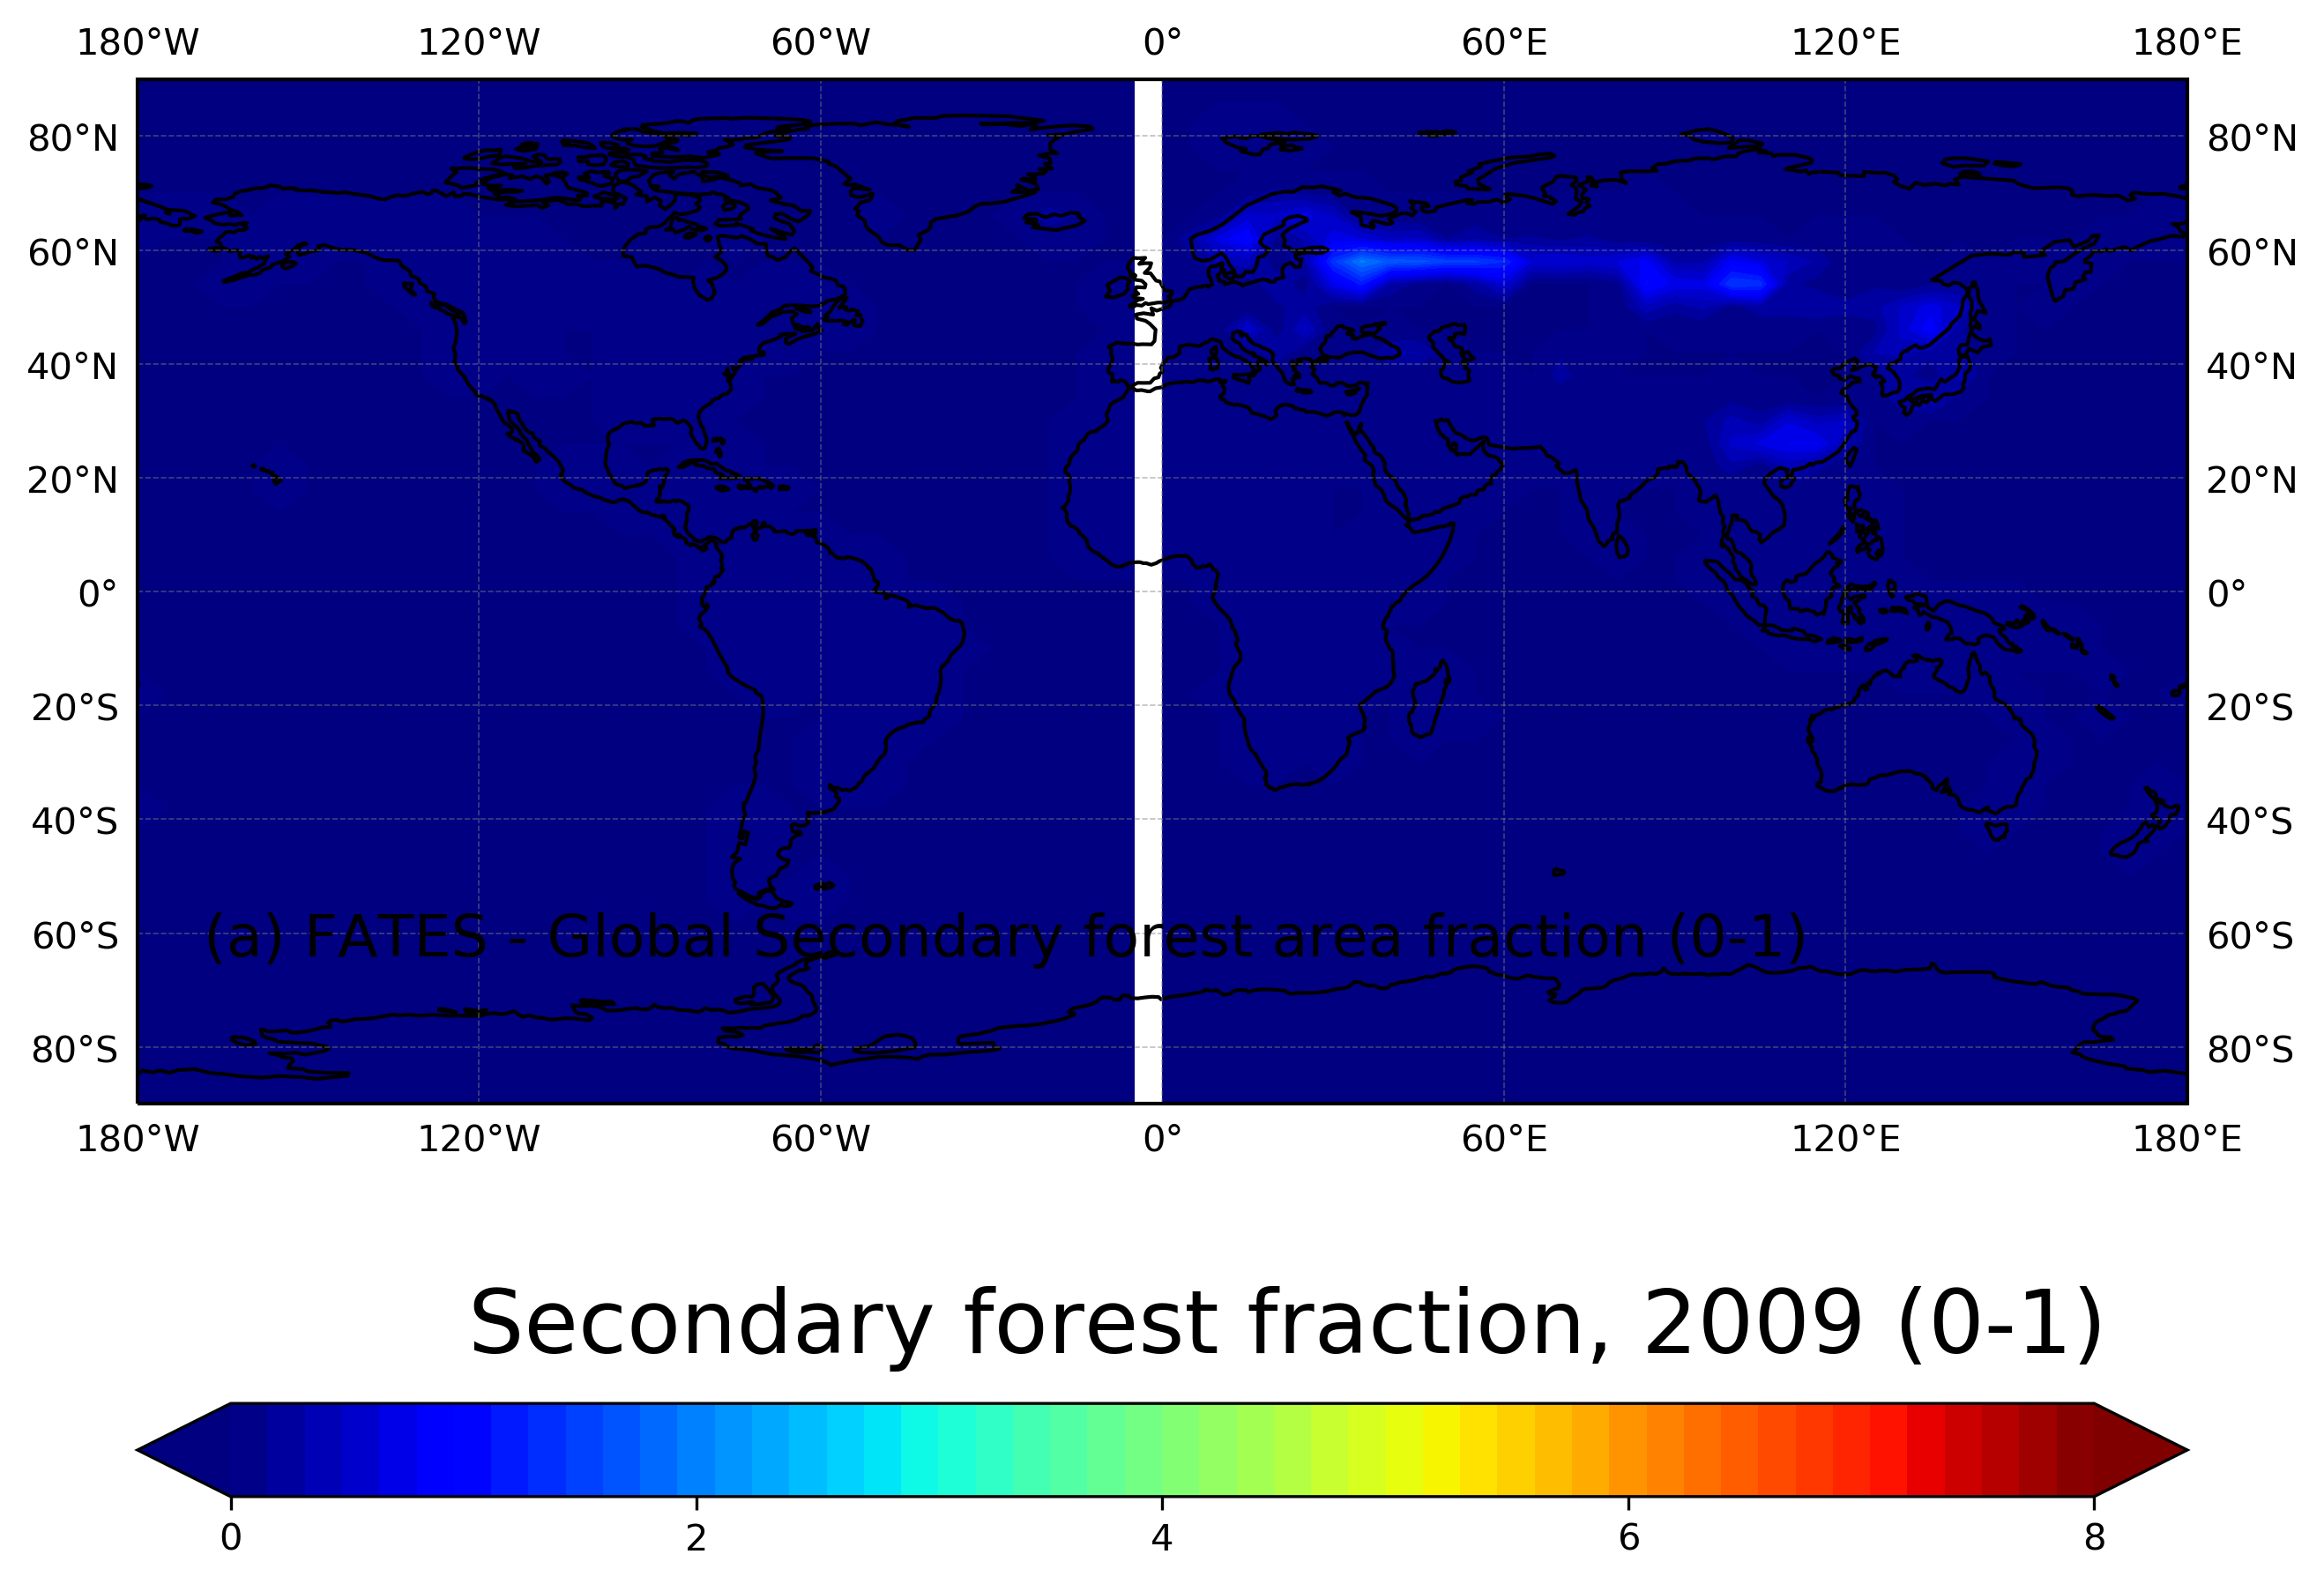

In [11]:
# Quick figures of harvest rate in kgC m-2
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, pri_hv[:,:], 60, levels=np.linspace(0.0, 8.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) FATES - Global Secondary forest area fraction (0-1)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest fraction, 2009 (0-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 2.0, 4.0, 6.0, 8.0] )
plt.show()

In [ ]:
# Write NC
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = nc4.Dataset('new.nc',mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
lat_dim = ncfile.createDimension('lat', 46)     # latitude axis
lon_dim = ncfile.createDimension('lon', 72)    # longitude axis
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)
ncfile.title='LUH2 harvest rate in kgC m-2'
print(ncfile.title)
ncfile.subtitle="Calculated from LUH2 biomass harvest rate and then aggregate from 1850 to 2015."
print(ncfile.subtitle)
print(ncfile)

# Define two variables with the same names as dimensions,
# a conventional way to define "coordinate variables".
lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon', np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'years since 1850-01-01'
time.long_name = 'time'
# Define a 3D variable to hold the data
pri_hv_rc = ncfile.createVariable('pri_hv',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
pri_hv_rc.units = 'KgC m-2' # degrees Kelvin
pri_hv_rc.standard_name = 'Harvested woody biomass from primary forest' # this is a CF standard name
print(pri_hv_rc)
sec_m_hv_rc = ncfile.createVariable('sec_m_hv',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
sec_m_hv_rc.units = 'KgC m-2' # degrees Kelvin
sec_m_hv_rc.standard_name = 'Harvested woody biomass from mature secondary forest' # this is a CF standard name
print(sec_m_hv_rc)
sec_y_hv_rc = ncfile.createVariable('sec_y_hv',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
sec_y_hv_rc.units = 'KgC m-2' # degrees Kelvin
sec_y_hv_rc.standard_name = 'Harvested woody biomass from young secondary forest' # this is a CF standard name
print(sec_y_hv_rc)
pri_hv_acc = ncfile.createVariable('pri_hv_acc',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
pri_hv_acc.units = 'KgC m-2' # degrees Kelvin
pri_hv_acc.standard_name = 'Harvested woody biomass from primary forest, accumulated from 1850 to 2015' # this is a CF standard name
print(pri_hv_acc)
sec_m_hv_acc = ncfile.createVariable('sec_m_hv_acc',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
sec_m_hv_acc.units = 'KgC m-2' # degrees Kelvin
sec_m_hv_acc.standard_name = 'Harvested woody biomass from mature secondary forest, accumulated from 1850 to 2015' # this is a CF standard name
print(sec_m_hv_acc)
sec_y_hv_acc = ncfile.createVariable('sec_y_hv_acc',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
sec_y_hv_acc.units = 'KgC m-2' # degrees Kelvin
sec_y_hv_acc.standard_name = 'Harvested woody biomass from young secondary forest, accumulated from 1850 to 2015' # this is a CF standard name
print(sec_y_hv_acc)

# Assign variables
lat[:] = latnc[:,0]
lon[:] = lonnc[0,:]
pri_hv_rc[:,:,:] = prif_hv_den + prin_hv_den
sec_m_hv_rc[:,:,:] = secmf_hv_den
sec_y_hv_rc[:,:,:] = secyf_hv_den + secn_hv_den
pri_hv_acc[:,:] = pri_hv
sec_m_hv_acc[:,:] = sec_m_hv
sec_y_hv_acc[:,:] = sec_y_hv

# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

In [9]:
# Open data
# Time series for ELM 0.5 x 0.5 deg
# nclu=NetCDFFile('landuse.timeseries_ne30np4_hist_simyr1850_2015_c20171018.nc','r')
# ncvar_area = nclu.variables['AREA'][:]
# ncvar_land = nclu.variables['LANDFRAC_PFT'][:]
# ncvar_pft = nclu.variables['PCT_NAT_PFT'][:]
# latnc = nclu.variables['LATIXY'][:]
# lonnc = nclu.variables['LONGXY'][:]
# nclu.close()

# area_halfxhalf = ncvar_area
# land_halfxhalf = ncvar_land
# pft_halfxhalf = ncvar_pft
# lat_halfxhalf = latnc
# lat_halfxhalf = lonnc

# Time series for ELM 4 x 5 deg
filename_in = 'landuse.timeseries_4x5_hist_harmonized_simyr1700-2015.biomass_harvest.nc'
ds = nc4.Dataset(filename_in)
ncvar_area = ds['AREA'][:]
ncvar_land = ds['LANDFRAC_PFT'][:]
ncvar_pft = ds['PCT_NAT_PFT'][:]
latnc = ds['LATIXY'][:]
lonnc = ds['LONGXY'][:]
ds.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
pft_4x5 = ncvar_pft
lat_4x5 = latnc
lat_4x5 = lonnc

# Comparison: areas of different PFTs, Unit in Mkm2
nyear = int(np.shape(ncvar_pft)[0])
npft = int(np.shape(ncvar_pft)[1])
totalarea_hxh = np.zeros((nyear, npft))
totalarea_4x5 = np.zeros((nyear, npft))
# Get the total area for each PFT
for iyear in np.arange(0,nyear):
    for ipft in np.arange(0,npft):
        areamap = area_halfxhalf * land_halfxhalf * pft_halfxhalf[iyear, ipft, :]
        sumarea_halfxhalf = np.nansum(np.nansum(areamap))/1e6
        totalarea_hxh[iyear, ipft] = sumarea_halfxhalf
        areamap = area_4x5 * land_4x5 * pft_4x5[iyear, ipft, :]      
        sumarea_4x5 = np.nansum(np.nansum(areamap))/1e6
        totalarea_4x5[iyear, ipft] = sumarea_4x5
        
#         print('Current pft', ipft, 'Current year', iyear, 'Area_hxh', sumarea_halfxhalf, 'Area_4x5', sumarea_4x5, \
#               'Area_diff', sumarea_halfxhalf-sumarea_4x5)

NameError: name 'area_halfxhalf' is not defined